In [19]:
# load packages

library(tidyverse)
library(pwr)
library(repr)
library(cowplot)
library(ggseqlogo)
library(reshape2)
library(gg.gap)

In [2]:
packageVersion("pwr")
packageVersion("repr")
packageVersion("cowplot")
packageVersion("ggseqlogo")
packageVersion("reshape2")
packageVersion("gg.gap")

[1] ‘1.3.0’

[1] ‘1.1.4’

[1] ‘1.1.1’

[1] ‘0.1’

[1] ‘1.4.4’

[1] ‘1.3’

# Functions

In [4]:
# HELPERS 


#' load_cgmap()
#' This function will load a text file containing CGmaps and add column headers
#'
#' @param cgmap path to CGmaps
#' @param strain strain designator (i.e "TS559", "TK2304", etc)
#' @param replicate i.e. "rep1"
#' @param growth phae exponential" or "stationary"
#' @param metabolic_condition S for sulfur
#'
#' @return dataframe 
load_cgmap <- function(cgmap,strain, replicate, growth_phase, metabolic_condition='S'){
    cols = c('chromosome', 'base', 'position', 'trinuc_context','dinuc_context', 
         "methylation_frequency", "count_mC", "coverage")
    outdata <- read.delim(cgmap, sep='\t', header=FALSE,col.names=cols) %>%
        mutate(strain=strain, growth_phase=growth_phase, 
               metabolic_condition=metabolic_condition, replicate=replicate)

}


#' processCGmap()
#' Fix some of the column names so they are unique for each strain
#'
#' @param cgmap: path to CGmaps
#'
#' @return dataframe 
processCGmap <- function(cgmap){
    strain = unique(cgmap$strain)
    rep = unique(cgmap$replicate)
    
    final_data <- cgmap %>% 
        dplyr::select(-trinuc_context, -dinuc_context) %>%
        dplyr::rename(!!paste("coverage","_",strain,"_",rep, sep="") := coverage) %>%
        dplyr::rename(!!paste("mC_count","_",strain,"_",rep, sep="") := count_mC) %>%
        dplyr::rename(!!paste("methylation_frequency","_",strain,"_",rep, sep="") := methylation_frequency) %>%
        dplyr::select(-replicate, -strain)
    return(final_data)
}


#' merge_del_2reps()
#' merge processed CGmaps for replicate deletion strains when there are 2 replicates
#'
#' @param x: processCGmap output for rep1
#' @param y: processCGmap output for rep2
#' @param strain: name of strain (i.e. "TS559", "TK2304", etc)
#'
#' @return dataframe 
merge_del_reps <- function(x,y, strain){
    cov_1 <- paste("coverage_",strain, "_rep1", sep='')
    cov_2 <- paste("coverage_",strain, "_rep2", sep='')

    d <- x %>%
        merge(y=y, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
    
            mutate(!!as.name(cov_1) := replace_na(!!as.name(cov_1),0)) %>%
            mutate(!!as.name(cov_2) := replace_na(!!as.name(cov_2),0))
    
    return(d)
}


#' merge_del_3reps()
#' merge processed CGmaps for replicate deletion strains when there are 3 replicates
#'
#' @param x: processCGmap output for rep1
#' @param y: processCGmap output for rep2
#' @param y: processCGmap output for rep3
#' @param strain: name of strain (i.e. "TS559", "TK2241", etc)
#'
#' @return dataframe
merge_del_3reps <- function(x,y,z,strain){
    cov_1 <- paste("coverage_",strain, "_rep1", sep='')
    cov_2 <- paste("coverage_",strain, "_rep2", sep='')
    cov_3 <- paste("coverage_",strain, "_rep3", sep='')

    d <- x %>%
        merge(y=y, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
        merge(y=z, 
              by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
              all=TRUE) %>%
            mutate(!!as.name(cov_1) := replace_na(!!as.name(cov_1),0)) %>%
            mutate(!!as.name(cov_2) := replace_na(!!as.name(cov_2),0)) %>%
            mutate(!!as.name(cov_3) := replace_na(!!as.name(cov_3),0))

    return(d)
}


#' detect_hiconf_3reps()
#' Determine if high confidence, reproducible sites when there are 3 replicates

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
detect_hiconf_3reps <- function(f1,m1,p1,c1,f2,m2,p2,c2,f3,m3,p3,c3, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c1) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    if( is.na(c3) ) {c3<-0}
    if(c1 < min_cov & c2 < min_cov & c3 < min_cov) {return(NA)}
    
    else{
    
    if(c1<min_cov){ls <- c(ls,NA)}
    else if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (m1>50 & f1>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c2<min_cov){ls <- c(ls,NA)}
    else if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (m2>50 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c3<min_cov){ls <- c(ls,NA)}
    else if( (c3>=min_cov & m3>=p3 & f3>=min_freq)| (m3>50 & f3>=min_freq2) )  {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    ans_t <- length(which(ls==TRUE))
    ans_na <- length(which(ls==NA))
    ans_f <- length(which(ls==FALSE))

    if(ans_na >= 3){return(NA)}
    if(ans_na == 2 & ans_t == 1){return(NA)}
    else if(ans_t >= 2){return(TRUE)}
    else { return(FALSE)}
        }
}


#' detect_hiconf_2reps()
#' Determine if high confidence, reproducible sites when there are 2 replicates

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
detect_hiconf_2reps <- function(f1,m1,p1,c1,f2,m2,p2,c2, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c2) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    
    if(c1 < min_cov & c2 < min_cov) {return(NA)}
    else{
            
    if(c1<min_cov){ls <- c(ls,NA)}
    else if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (m1>50 & f1>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if(c2<min_cov){ls <- c(ls,NA)}
    else if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (m2>50 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}

    ans_t <- length(which(ls==TRUE))
    ans_na <- length(which(ls==NA))
    ans_f <- length(which(ls==FALSE))

    if(ans_f == 1 & ans_t == 1 ){return(TRUE)}
    if(ans_f >= 1  ){return(FALSE)}
    else if(ans_t >= 2){return(TRUE)}
    else if(ans_t == 1 & ans_na ==1){return(TRUE)}
    else if(ans_f == 1 & ans_na ==1){return(FALSE)}

    else { return(NA)}
        
        }
}


#' super_hiconf_3reps()
#' Determine if high confidence in all 3 replicates (super high confidence)

#' @param f  measured m5C frequency
#' @param m  measured m5C coverage
#' @param p  99 percentile m5C coverage
#' @param c  total coverage
#' @param min_cov  minimum coverage for high confidence threshold
#' @param min_freq  .1 minimum m5C frequency high confidence threshold
#' @param min_freq2  ..5 minimum m5C frequency high confidence threshold when coverage >=1000
#'
#' @return TRUE, FALSE, NA
super_hiconf_3reps <- function(f1,m1,p1,c1,f2,m2,p2,c2,f3,m3,p3,c3, min_cov=47,
                                min_freq=.10, min_freq2 = 0.05) {
    ls <- c()
    
    if( is.na(c1) ) {c1<-0}
    if( is.na(c2) ) {c2<-0}
    if( is.na(c3) ) {c3<-0}

    
    if(  (c1>=min_cov & m1>=p1 & f1>=min_freq) | (c1>1000 & f1>=min_freq2)  ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    
    if( (c2>=min_cov & m2>=p2 & f2>=min_freq) | (c2>=1000 & f2>=min_freq2) ) {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    if( (c3>=min_cov & m3>=p3 & f3>=min_freq) | (c3>=1000 & f3>=min_freq2) )  {ls <- c(ls,TRUE)}
    else {ls <- c(ls,FALSE)}
    
    ans <- length(which(ls==TRUE))
    
    if(ans >= 3){return(TRUE)}
    else { return(FALSE)}
}



#' rm_overlap()
#' Determine if the deletion strain and parent/control strain m5C frequencies have  
#'    a 90% confidence interval overlap 

#' @param sp  deletion strain m5C frequency
#' @param ssd deletion strain m5C frequency standard deviation
#' @param c  control strain m5C frequency
#' @param csd control strain m5C frequency standard deviation
#'
#' @return TRUE, FALSE
rm_overlap <- function(sp, ssd, cp,csd){
    ssd <- ssd*1.645
    csd <- csd*1.645

    r1 <- c(sp-ssd, sp+ssd)
    r2 <- c(cp-csd, cp+csd)
    ans <- r1 %overlaps% r2
    return(ans)
    
}


#' get_sd()
#' Calculate m5C frequency standard deviation when 3 replicates are available
#'
#' @param f1  m5C frequency rep1
#' @param f2  m5C frequency rep2
#' @param f3  m5C frequency rep3
#' @param c1 site coverage rep1
#' @param c2 site coverage rep2
#' @param c3 site coverage rep3

#' @return standard deviation
get_sd <- function(f1,f2,f3,c1,c2,c3,min_cov){
    ls <-c()
    
    if(c1>=min_cov){
        ls <- c(ls,f1)
    }
    if(c2>=min_cov){
        ls <- c(ls, f2)

    }
    
    if(c3>=min_cov){
       ls <- c(ls, f3)

    }
    if (length(ls>1)){
        ans = round(sd(ls),3)
    } else{
        ans = NA
    }
    return(ans)
}


#' get_sd_2reps()
#' Calculate m5C frequency standard deviation when 2 replicates are available
#'
#' @param f1  m5C frequency rep1
#' @param f2  m5C frequency rep2
#' @param f3  m5C frequency rep3
#' @param c1 site coverage rep1
#' @param c2 site coverage rep2
#' @param c3 site coverage rep3

#' @return standard deviation
get_sd_2reps <- function(f1,f2,c1,c2,min_cov=47){
    ls <-c()
    if(c1>=min_cov){
        ls <- c(ls,f1)
    }
    if(c2>=min_cov){
        ls <- c(ls, f2)
    }
    if (length(ls>1)){
        ans = round(sd(ls),3)
    } else{
        ans = NA
    }
    return(ans)
}


#' get_pvalue()
#' get p value for each m5C site using binomial distribution when 2 replicates available for deletion strain
#'    the m5C and total coverage are pooled accross replicates.

#' @param s1_mC  deletion strain rep1 m5C coverage
#' @param s1_cov deletion strain rep1 total coverage
#' @param s2_mC  deletion strain rep2 m5C coverage
#' @param s2_cov deletion strain rep2 total coverage
#' @param c1_mC  control strain rep1 m5C coverage
#' @param c1_cov control strain rep1 total coverage
#' @param c2_mC  control strain rep2 m5C coverage
#' @param c2_cov control strain rep2 total coverage
#' @param c3_mC  control strain rep3 m5C coverage
#' @param c3_cov control strain rep3 total coverage
#'
#' @return pvalue
get_pvalue <- function(s1_mC,s1_cov, s2_mC,s2_cov,
                       c1_mC,c1_cov,c2_mC,c2_cov,c3_mC,c3_cov){
    
    
    if(s1_cov == 0 & s2_cov == 0){return(NA)} 
    if(c1_cov == 0 & c2_cov == 0){return(NA)} 

    else{

    sample_success = s1_mC + s2_mC  + 1
    sample_failure = (s1_cov+s2_cov)-sample_success  +1
    
    control_success = c1_mC + c2_mC + c3_mC  +1
    control_failure = (c1_cov + c2_cov + c3_cov) - control_success  +1
    
    if(is.na(sample_failure) |  is.na(control_failure) |
      is.na(sample_failure) | is.na(sample_failure)
      
      ){return(NA)}
    
    treatment <- c('sample','control')
    success <- c(sample_success, control_success)
    failure <- c(sample_failure, control_failure)
        
    da <- data.frame(treatment, success, failure)
        da$success <- as.integer(da$success)
        da$failure <- as.integer(da$failure)
        da$treatment <- as.factor(da$treatment)

        table <- cbind(da$success,da$failure)

    fit <- glm(table ~ treatment, family = binomial, data = da)
    p_val <- summary(fit)$coefficients[8]
    return(p_val) 
    }
}


#' get_pvalue_3reps()
#' get p value for each m5C site using binomial distribution when 2 replicates available for deletion strain
#'    the m5C and total coverage are pooled accross replicates.

#' @param s1_mC  deletion strain rep1 m5C coverage
#' @param s1_cov deletion strain rep1 total coverage
#' @param s2_mC  deletion strain rep2 m5C coverage
#' @param s2_cov deletion strain rep2 total coverage
#' @param s3_mC  deletion strain rep3 m5C coverage
#' @param s3_cov deletion strain rep3 total coverage
#' @param c1_mC  control strain rep1 m5C coverage
#' @param c1_cov control strain rep1 total coverage
#' @param c2_mC  control strain rep2 m5C coverage
#' @param c2_cov control strain rep2 total coverage
#' @param c3_mC  control strain rep3 m5C coverage
#' @param c3_cov control strain rep3 total coverage
#'
#' @return pvalue
get_pvalue_3reps <- function(s1_mC,s1_cov, s2_mC,s2_cov,s3_mC,s3_cov,
                       c1_mC,c1_cov,c2_mC,c2_cov,c3_mC,c3_cov){
    
    
    if(s1_cov == 0 & s2_cov==0 & s3_cov == 0){return(NA)} 
    if(c1_cov == 0 & c2_cov==0 & c3_cov == 0){return(NA)} 

    sample_success = s1_mC + s2_mC + s3_mC +1
    sample_failure = (s1_cov + s2_cov + s3_cov)-sample_success +1
    
    control_success = c1_mC + c2_mC + c3_mC +1
    control_failure = (c1_cov + c2_cov + c3_cov) - control_success +1
        
    if(is.na(sample_failure) |  is.na(control_failure) |
      is.na(sample_failure) | is.na(sample_failure) ){return(NA)}
    
    treatment <- c('sample','control')
    success <- c(sample_success, control_success)
    failure <- c(sample_failure,control_failure)
        
    da <- data.frame(treatment, success, failure)
        da$success <- as.integer(da$success)
        da$failure <- as.integer(da$failure)
        da$treatment <- as.factor(da$treatment)

        table <- cbind(da$success,da$failure)

    fit <- glm(table ~ treatment, family = binomial, data = da)
    p_val <- summary(fit)$coefficients[8]
    return(p_val)
}
    

#' get_quantiles()
#' calculate the 99% m5C coverage for a given library/cgmap where total coverage >= 47x

#' @param strain_cgmap  merged, processed CGmap
#' @param strain strain name (i.e. "TS559", "TK2304", etc)
#' @param reps number of replicates in dataset
#' @param min_cov minimum total coverage for high confidence threshold

#'
#' @return (int) 99% m5C coverage
get_quantiles <- function(strain_cgmap, strain, reps = 2, min_cov=47){
    
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    #get quantile values for m5C count
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    q <- c(q_strain_rep1, q_strain_rep2)
    
    if(reps==3){
        m5C_count_r3 <- paste("mC_count_", strain, "_rep3", sep="")
        cov_r3 <- paste("coverage_", strain, "_rep3", sep="")
        
        q_strain_rep3 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r3)>=min_cov, !!as.name(m5C_count_r3)>=0) )[[m5C_count_r3]], .99)[[1]]
        
        q = c(q, q_strain_rep3)
    }
    
    return(q)
}
    

#' get_difference()
#' determine in what way the m5C site in the deletion strain differs from the same site in the parent strain

#' @param hiconf_TS559  whether this site is high confidence in parent strain TS559
#' @param hiconf_strain whether this site is high confidence in deletion strain
#' @param strain_poolf m5C modification frequency in deletion strain
#' @param control_poolf m5C modification frequency in parent strain
#'
#' @return (string) nature of change 
    #' eg. REL LOSS (relative, but not compete loss in m5C signal)
    #' eg. ABS LOSS (absolute loss in m5C signal in deletion strain)
get_difference <- function(hiconf_TS559, hiconf_strain, strain_poolf, control_poolf, CI90_overlap){
    
    if(is.na(hiconf_TS559) | is.na(hiconf_strain)){return(NA)}
    else if(is.na(CI90_overlap)){return(NA)}
    
    else if(hiconf_TS559 == FALSE & hiconf_strain == FALSE){return("NOT MODIFIED")}
    else if(CI90_overlap == TRUE){return("OUTSIDE OF DIFFERENTIATION LIMITS")}

    else if(hiconf_TS559 == TRUE & hiconf_strain == FALSE & strain_poolf <= 0.02){return("ABS LOSS")} 
    else if(hiconf_TS559 == TRUE & hiconf_strain == FALSE & strain_poolf > 0.02){return("REL LOSS")} 

    else if(hiconf_TS559 == FALSE & hiconf_strain == TRUE & control_poolf <= 0.02){return("ABS GAIN")}
    else if(hiconf_TS559 == FALSE & hiconf_strain == TRUE & control_poolf > 0.02){return("REL GAIN")}

    else if(hiconf_TS559 == TRUE & hiconf_strain == TRUE & strain_poolf > control_poolf){return("REL GAIN")} 
    else if(hiconf_TS559 == TRUE & hiconf_strain == TRUE & strain_poolf < control_poolf){return("REL LOSS")} 
    
    else{return("error")}
    }


#' CompareCGmap()
#' The Big One. We will compare the CGmaps of the deletion strain and parent strain using functions defined up to this point
#'        and generate a final dataset provided in supplementary files

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param TS559_cgmap merged cgmap for parent strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param annotation dataframe containing complete annotation for each site
#' @param minimum_freq minimum m5C modification for high confidence threshold
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe that contains sites where a difference was detected between control and deletion strains
CompareCGmap <- function(strain_cgmap, TS559_cgmap, strain, annotation, minimum_freq=.10, min_cov=47){
    
    #making some column names
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    pooled_methylation_frequency_strain <- paste("pooled_methylation_frequency_", strain, sep='')

    #get quantile values for m5C count
    q_TS559_rep1 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep1>=min_cov, mC_count_TS559_rep1>=0))$mC_count_TS559_rep1, .99)[[1]]
    
    q_TS559_rep2 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep2>=min_cov, mC_count_TS559_rep2>=0))$mC_count_TS559_rep2, .99)[[1]]
    
    q_TS559_rep3 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep3>=min_cov, mC_count_TS559_rep3>=0))$mC_count_TS559_rep3, .99)[[1]]

    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    #build dataframe
    data <- strain_cgmap %>%
        merge(y = TS559_cgmap, all = TRUE, 
             by= c("chromosome","position","reference_nucleotide","growth_phase","metabolic_condition")) %>%
        dplyr::select(-chromosome,-standard_devition) %>%
    
        # house keeping
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%
        
        mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
        mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
        mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%
    rowwise() %>%
        mutate(hiconf_TS559 = detect_hiconf_3reps(
            f1=methylation_frequency_TS559_rep1,
            m1=mC_count_TS559_rep1,
            p1=q_TS559_rep1,
            c1=coverage_TS559_rep1,
            f2=methylation_frequency_TS559_rep2,
            m2=mC_count_TS559_rep2,
            p2=q_TS559_rep2,
            c2=coverage_TS559_rep2,
            f3=methylation_frequency_TS559_rep3,
            m3=mC_count_TS559_rep3,
            p3=q_TS559_rep3,
            c3=coverage_TS559_rep3,
            min_cov=min_cov,
            min_freq = minimum_freq) 
              ) %>%
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov= min_cov,
                min_freq = minimum_freq)
                 
                ) %>%
    
    # keep sites where m5C is high confidence in either strain
    filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
    filter(!is.na(hiconf_TS559) & !is.na(hiconf_strain)) %>%

    # calculate the mean m5C frequency at each site by pooling replicates (round to 2 decimals)
    # calculate standard deviation of each site as well
    mutate(!!as.name(pooled_methylation_frequency_strain) := 
             ( !!as.name(m5C_count_r1) +  !!as.name(m5C_count_r2) ) / ( !!as.name(cov_r1) + !!as.name(cov_r2) ) ) %>%
        
    mutate(!!as.name(pooled_methylation_frequency_strain) := round(!!as.name(pooled_methylation_frequency_strain),2))%>%
    mutate(strain_sd = sd(c(!!as.name(meth_freq_r1),!!as.name(meth_freq_r2))))%>%
    
    mutate(pooled_methylation_frequency_TS559 =
               (mC_count_TS559_rep1 + mC_count_TS559_rep2 + mC_count_TS559_rep3) /
               (coverage_TS559_rep1+coverage_TS559_rep2+coverage_TS559_rep3)    ) %>%
    mutate(pooled_methylation_frequency_TS559=round(pooled_methylation_frequency_TS559,2)) %>%
    mutate(TS559_sd = sd(c(methylation_frequency_TS559_rep1,methylation_frequency_TS559_rep2,
                              methylation_frequency_TS559_rep3))) %>%

    # calculate fold change of methylaton frequency at each site between parent and deletion strain
    mutate(FoldChange = (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01),
           log2FC = log2( (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01) ) ) %>%
    
    mutate(CI90_overlap = 
                   rm_overlap(!!as.name(pooled_methylation_frequency_strain), strain_sd,
                    pooled_methylation_frequency_TS559, TS559_sd )) %>%
    
    mutate(difference = get_difference(hiconf_TS559, hiconf_strain,   
                                            !!as.name(pooled_methylation_frequency_strain), 
                                            pooled_methylation_frequency_TS559,
                                            CI90_overlap
                                      ) ) %>%
    filter(difference == "ABS LOSS" | difference == "REL LOSS" | difference == "ABS GAIN" | 
           difference == "REL GAIN" | difference == "error") %>%
    filter(log2FC >= 1 | log2FC <= -1) %>%

    # add p vlaue
    rowwise() %>%
    mutate(pvalue = get_pvalue(
            s1_mC = !!as.name(m5C_count_r1),
            s1_cov = !!as.name(cov_r1), 
            s2_mC = !!as.name(m5C_count_r2),
            s2_cov = !!as.name(cov_r2),
            c1_mC = mC_count_TS559_rep1,
            c1_cov = coverage_TS559_rep1,
            c2_mC = mC_count_TS559_rep2,
            c2_cov = coverage_TS559_rep2,
            c3_mC = mC_count_TS559_rep3,
            c3_cov = coverage_TS559_rep3) ) %>%
    
    filter(!is.na(pvalue), pvalue <= 0.01)
    
        
    # adjust p values
    # adj_pvalue <- p.adjust(data$pvalue, method = 'fdr')
    #data <- cbind(data, adj_pvalue)
    
    data <- data %>% merge(y=annotation,by='position', all.x=TRUE) %>%
            dplyr::rename(TS559_position = position) %>%
           #filter(CI90_overlap==TRUE) %>%
           dplyr::select(-reproducible, -highly_reproducible,-reference_nucleotide) %>%
           arrange(log2FC) %>%
           arrange(difference) %>%
           dplyr::select(TS559_position, KOD1_position, strand, everything())
    
  
    return(data)
}


#' CompareCGmap_3reps()
#' When 3 reps are aavilable We will compare the CGmaps of the deletion strain and 
#'        parent strain using functions defined up to this point
#'        and generate a final dataset provided in supplementary files
#'
#' @param strain_cgmap  merged cgmap for deletion strain
#' @param TS559_cgmap merged cgmap for parent strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param annotation dataframe containing complete annotation for each site
#' @param minimum_freq minimum m5C modification for high confidence threshold
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe that contains sites where a difference was detected between control and deletion strains
CompareCGmap_3reps <- function(strain_cgmap, TS559_cgmap, strain, annotation, minimum_freq=.10, min_cov=47){
    
    #making some column names
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    
    meth_freq_r3 <- paste("methylation_frequency_", strain, "_rep3", sep="")
    m5C_count_r3 <- paste("mC_count_", strain, "_rep3", sep="")
    cov_r3 <- paste("coverage_", strain, "_rep3", sep="")
    
    
    pooled_methylation_frequency_strain <- paste("pooled_methylation_frequency_", strain, sep='')

    #get quantile values for m5C count
    q_TS559_rep1 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep1>=min_cov, mC_count_TS559_rep1>=0))$mC_count_TS559_rep1, .99)[[1]]
    
    q_TS559_rep2 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep2>=min_cov, mC_count_TS559_rep2>=0))$mC_count_TS559_rep2, .99)[[1]]
    
    q_TS559_rep3 <- quantile((TS559_cgmap%>%
        filter(coverage_TS559_rep3>=min_cov, mC_count_TS559_rep3>=0))$mC_count_TS559_rep3, .99)[[1]]

    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
   
    q_strain_rep3 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r3)>=min_cov, !!as.name(m5C_count_r3)>=0) )[[m5C_count_r3]], .99)[[1]] 
    
    #build dataframe
    data <- strain_cgmap %>%
        merge(y = TS559_cgmap, all = TRUE, 
             by= c("chromosome","position","reference_nucleotide","growth_phase","metabolic_condition")) %>%
        dplyr::select(-chromosome,-standard_devition) %>%
    
        # If coverage is NA, it is also 0
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%
        mutate(!!as.name(cov_r3) := replace_na(!!as.name(cov_r3),0)) %>%

        mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
        mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
        mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%  
                                                      
        # identify high confidence and reproducible m5C sites
        rowwise() %>%
        mutate(hiconf_TS559 = detect_hiconf_3reps(
            f1=methylation_frequency_TS559_rep1,
            m1=mC_count_TS559_rep1,
            p1=q_TS559_rep1,
            c1=coverage_TS559_rep1,
            f2=methylation_frequency_TS559_rep2,
            m2=mC_count_TS559_rep2,
            p2=q_TS559_rep2,
            c2=coverage_TS559_rep2,
            f3=methylation_frequency_TS559_rep3,
            m3=mC_count_TS559_rep3,
            p3=q_TS559_rep3,
            c3=coverage_TS559_rep3,
            min_cov=min_cov,
            min_freq = minimum_freq) 
              ) %>%
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_3reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                f3=!!as.name(meth_freq_r3),
                m3=!!as.name(m5C_count_r3),
                p3=q_strain_rep3,
                c3=!!as.name(cov_r3), 
                min_cov= min_cov,
                min_freq = minimum_freq)
                 
                ) %>%
        # we are only interested in keeping sites were either the parent or deletion
        # strain have a high-confidence m5C site
        filter(hiconf_TS559 == TRUE | hiconf_strain == TRUE) %>%
        filter(!is.na(hiconf_TS559) & !is.na(hiconf_strain)) %>%
                                                    
                                                          
        # calculate the mean m5C frequency at each site by pooling replicates (round to 2 decimals)
        # calculate standard deviation of each site as well
        mutate(
                !!as.name(pooled_methylation_frequency_strain) := 
                ( !!as.name(m5C_count_r1) + !!as.name(m5C_count_r2) + !!as.name(m5C_count_r3) )/ 
                ( !!as.name(cov_r1) + !!as.name(cov_r2) + !!as.name(cov_r3) ) 
              ) %>%
    
        
        mutate(!!as.name(pooled_methylation_frequency_strain) := 
               round(!!as.name(pooled_methylation_frequency_strain),2)
              ) %>%
        mutate(strain_sd = sd(c(!!as.name(meth_freq_r1),!!as.name(meth_freq_r2),!!as.name(meth_freq_r3)))
              )%>%
    
        mutate(pooled_methylation_frequency_TS559 =
               (mC_count_TS559_rep1 + mC_count_TS559_rep2 + mC_count_TS559_rep3) /
               (coverage_TS559_rep1+coverage_TS559_rep2+coverage_TS559_rep3)    ) %>%
        mutate(pooled_methylation_frequency_TS559=round(pooled_methylation_frequency_TS559,2)) %>%
        mutate(TS559_sd = sd(c(methylation_frequency_TS559_rep1,methylation_frequency_TS559_rep2,
                              methylation_frequency_TS559_rep3))) %>%
    

        # calculate fold change of methylaton frequency at each site between parent and deletion strain
        mutate(FoldChange = (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01),
               log2FC = log2( (!!as.name(pooled_methylation_frequency_strain)+.01) / 
                               (pooled_methylation_frequency_TS559+.01) ) ) %>%
        
        mutate(CI90_overlap = 
                   rm_overlap(!!as.name(pooled_methylation_frequency_strain), strain_sd,
                    pooled_methylation_frequency_TS559, TS559_sd )) %>%
    
        mutate(difference = get_difference(hiconf_TS559, hiconf_strain,   
                                            !!as.name(pooled_methylation_frequency_strain), 
                                            pooled_methylation_frequency_TS559,
                                            CI90_overlap
                                      ) ) %>%
        filter(difference == "ABS LOSS" | difference == "REL LOSS" | difference == "ABS GAIN" | 
           difference == "REL GAIN" | difference == "error") %>%
        filter(log2FC >= 1 | log2FC <= -1) %>%

    
        # add p vlaue
        rowwise() %>%
        mutate(pvalue = get_pvalue_3reps(
            s1_mC = !!as.name(m5C_count_r1),
            s1_cov = !!as.name(cov_r1), 
            s2_mC = !!as.name(m5C_count_r2),
            s2_cov = !!as.name(cov_r2),
            s3_mC = !!as.name(m5C_count_r3),
            s3_cov = !!as.name(cov_r3),
            c1_mC = mC_count_TS559_rep1,
            c1_cov = coverage_TS559_rep1,
            c2_mC = mC_count_TS559_rep2,
            c2_cov = coverage_TS559_rep2,
            c3_mC = mC_count_TS559_rep3,
            c3_cov = coverage_TS559_rep3) ) %>%
        
    
        filter(!is.na(pvalue), pvalue <= 0.0)
            
        # adjust p values
        # adj_pvalue <- p.adjust(data$pvalue, method = 'fdr')
        # data <- cbind(data, adj_pvalue)
    
        data <- data %>% merge(y=annotation,by='position', all.x=TRUE) %>%
            dplyr::rename(TS559_position = position) %>%
           dplyr::select(-reproducible, -highly_reproducible, -reference_nucleotide) %>%
           arrange(log2FC) %>%
            arrange(difference) %>%
            dplyr::select(TS559_position, KOD1_position, strand, everything())
    
    return(data)
}
    
        
#' enumerate_hiconf_2reps()
#' Include all high confidence m5C sites in strain when 2 replicates are available
#'      irrespective of control strain

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe
enumerate_hiconf_2reps <- function(strain_cgmap, strain, min_cov=47){
    
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    data <- strain_cgmap %>%
        dplyr::select(-chromosome, -reference_nucleotide,-growth_phase) %>%
    
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%  
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov=min_cov)
                 
                ) %>%
        dplyr::rename(TS559_position = position) %>%
        
        mutate( 'm5C_cov/total_cov_rep1' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep1',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep1',sep='')) 
                 ) 
              ) %>%
        
        mutate( 'm5C_cov/total_cov_rep2' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep2',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep2',sep='')) 
                 ) 
              ) %>%
        dplyr::select(TS559_position, 
                  !!as.name(meth_freq_r1), 
                  'm5C_cov/total_cov_rep1',
                  !!as.name(meth_freq_r2), 
                  'm5C_cov/total_cov_rep2',
                     hiconf_strain) %>%

    dplyr::rename(!!paste(strain,'_hiconf',sep=''):= hiconf_strain )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep1',sep=''):= 'm5C_cov/total_cov_rep1' )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep2',sep=''):= 'm5C_cov/total_cov_rep2' ) %>%
    dplyr::rename(!!paste('freq_',strain,'_rep1',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep1',sep='') ) )%>%
    dplyr::rename(!!paste('freq_',strain,'_rep2',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep2',sep='') ) )  
    
    return(data)
}

        
        
#' enumerate_hiconf_3reps()
#' Include all high confidence m5C sites in strain when 3 replicates are available
#'      irrespective of control strain

#' @param strain_cgmap  merged cgmap for deletion strain
#' @param strain name of deletion strain (i.e/ "TK2304")
#' @param min_cov m5C minimum coverage for high confidence threshold
#'
#' @return dataframe
enumerate_hiconf_3reps <- function(strain_cgmap, strain, min_cov=47){
    
    meth_freq_r1 <- paste("methylation_frequency_", strain, "_rep1", sep="")
    m5C_count_r1 <- paste("mC_count_", strain, "_rep1", sep="")
    cov_r1 <- paste("coverage_", strain, "_rep1", sep="")

    meth_freq_r2 <- paste("methylation_frequency_", strain, "_rep2", sep="")
    m5C_count_r2 <- paste("mC_count_", strain, "_rep2", sep="")
    cov_r2 <- paste("coverage_", strain, "_rep2", sep="")
    
    q_strain_rep1 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r1)>=min_cov, !!as.name(m5C_count_r1)>=0) )[[m5C_count_r1]], .99)[[1]]
    
    q_strain_rep2 <- quantile(
        (strain_cgmap %>%
        filter(!!as.name(cov_r2)>=min_cov, !!as.name(m5C_count_r2)>=0) )[[m5C_count_r2]], .99)[[1]]
    
    
    data <- strain_cgmap %>%
        dplyr::select(-chromosome, -reference_nucleotide,-growth_phase) %>%
    
        mutate(!!as.name(cov_r1) := replace_na(!!as.name(cov_r1),0)) %>%
        mutate(!!as.name(cov_r2) := replace_na(!!as.name(cov_r2),0)) %>%   
        
        rowwise() %>%
        mutate(hiconf_strain = detect_hiconf_2reps(
                f1=!!as.name(meth_freq_r1),
                m1=!!as.name(m5C_count_r1),
                p1=q_strain_rep1,
                c1=!!as.name(cov_r1),
                f2=!!as.name(meth_freq_r2),
                m2=!!as.name(m5C_count_r2),
                p2=q_strain_rep2,
                c2=!!as.name(cov_r2), 
                min_cov=min_cov)
                 
                ) %>%
        dplyr::rename(TS559_position = position) %>%
        
        mutate( 'm5C_cov/total_cov_rep1' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep1',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep1',sep='')) 
                 ) 
              ) %>%
        
        mutate( 'm5C_cov/total_cov_rep2' := 
            paste(!!as.name(paste('mC_count_',strain,'_rep2',sep='')), 
                  '/', 
                  !!as.name(paste('coverage_',strain,'_rep2',sep='')) 
                 ) 
              ) %>%
        dplyr::select(TS559_position, 
                  !!as.name(meth_freq_r1), 
                  'm5C_cov/total_cov_rep1',
                  !!as.name(meth_freq_r2), 
                  'm5C_cov/total_cov_rep2',
                     hiconf_strain) %>%

    dplyr::rename(!!paste(strain,'_hiconf',sep=''):= hiconf_strain )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep1',sep=''):= 'm5C_cov/total_cov_rep1' )  %>%
    dplyr::rename(!!paste('m5C_cov/total_cov_',strain,'_rep2',sep=''):= 'm5C_cov/total_cov_rep2' ) %>%
    dplyr::rename(!!paste('freq_',strain,'_rep1',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep1',sep='') ) )%>%
    dplyr::rename(!!paste('freq_',strain,'_rep2',sep=''):= !!as.name(paste('methylation_frequency_',strain,'_rep2',sep='') ) )  
    
    return(data)
}

In [6]:
# load CGmaps for control strain TS559

TS559exoS_CGmap_rep1 <-load_cgmap("./cgmaps/TS559_exoS_totalRNA_rep1.CGmap",
    strain="TS559", growth_phase='exoponential', metabolic_condition="S",replicate="rep1") %>%
    dplyr::rename(reference_nucleotide=base)

TS559statS_CGmap_rep1 <-load_cgmap("./cgmaps/TS559_statS_totalRNA_rep1.CGmap",
    strain="TS559", growth_phase='stationary', metabolic_condition="S",replicate="rep1")%>%
    dplyr::rename(reference_nucleotide=base)

TS559exoS_CGmap_rep2 <-load_cgmap("./cgmaps/TS559_exoS_totalRNA_rep2.CGmap", 
    strain="TS559", growth_phase='exoponential', metabolic_condition="S",replicate="rep2")%>%
    dplyr::rename(reference_nucleotide=base)

TS559statS_CGmap_rep2 <-load_cgmap("./cgmaps/TS559_statS_totalRNA_rep2.CGmap",
    strain="TS559", growth_phase='stationary', metabolic_condition="S",replicate="rep2")%>%
    dplyr::rename(reference_nucleotide=base)

TS559exoS_CGmap_rep3 <-load_cgmap("./cgmaps/TS559_exoS_totalRNA_rep3.CGmap",
    strain="TS559", growth_phase='exoponential', metabolic_condition="S",replicate="rep3")%>%
    dplyr::rename(reference_nucleotide=base)

TS559statS_CGmap_rep3 <-load_cgmap("./cgmaps/TS559_statS_totalRNA_rep3.CGmap",
    strain="TS559", growth_phase='stationary', metabolic_condition="S",replicate="rep3")%>%
    dplyr::rename(reference_nucleotide=base)


# process CGmaps for control strain TS559
TS559exoS_rep1_df <- processCGmap(TS559exoS_CGmap_rep1)
TS559exoS_rep2_df <- processCGmap(TS559exoS_CGmap_rep2)
TS559exoS_rep3_df <- processCGmap(TS559exoS_CGmap_rep3)

TS559statS_rep1_df <- processCGmap(TS559statS_CGmap_rep1)
TS559statS_rep2_df <- processCGmap(TS559statS_CGmap_rep2)
TS559statS_rep3_df <- processCGmap(TS559statS_CGmap_rep3)

In [174]:
# load annotation dataset. see M&M for details

annotation <- data.frame(read_delim('./supporting_data/annotation_ready', delim = '\t') %>%
    dplyr::rename(position=TS559_position) )
head(annotation)

Rows: 1876 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (20): KOD1_position, strand, logos_sequence_41bp, element_name, element_...
dbl  (2): TS559_position, total_annotations

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,position,KOD1_position,strand,logos_sequence_41bp,element_name,element_type,element_description,element_length,position_in_transcript,percent_position_in_transcript,⋯,amino_acid_sequence,amino_acid_ID,local_41bp_predicted_fold,m5C_position_fold,MFE,associated_TSS_id,TSS_direction,TSS_description,total_annotations,alternate_annotations
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,857,857,+,UGAAGCCGUCUUCGGUCAGCCGAAGGAGAAGGUUUACGCUG,TK0001,mRNA,DNA-directed DNA polymerase%2C family B,5016,857,17.1,⋯,CCG,P,....||||||||||||||||...................||,single_stranded,-264.99,.,.,.,1,NA
2,12052,12052,+,AGUCCGCUUCCCGAAGAAUACUACCAACUCUGGCUUGAGUA,TK0014,mRNA,metal-dependent phosphohydrolase%2C HD superfamily,558,324,58.1,⋯,UAC,Y,|...||||||||..|........|||....|||........,single_stranded,-30.73,.,.,.,1,NA
3,15330,15330,+,GGAGCAUCCAAAGUUUAGUGCGGGAUUUCAGAUUCAUAAUC,TK0019,mRNA,predicted ABC-type transport system%2C ATPase component,1020,386,37.8,⋯,GCG,A,...............|..||||||.................,base_paired,-34.57,.,.,.,1,NA
4,19557,19557,-,GUCAACUUCGUUGACGGGACCGAUGGAAGGGUGAUAAGAGC,TK0024,mRNA,hypothetical protein%2C conserved,894,627,70.1,⋯,ACC,T,.........||..||||||||..||||..........||||,base_paired,-68.4,.,.,.,1,NA
5,20243,20243,-,GCUGCCCUCGGCUGGGUCGCCGGCAGUAAGGCCCUCGAAGG,TK0025,mRNA,hypothetical membrane protein%2C conserved,990,930,93.9,⋯,GCC,A,..|||||.||...|||||||||||.....||||||||....,base_paired,-63.03,.,.,.,1,NA
6,22822,22822,-,CUUGUGAAUCUAGCCGCUGCCGACGGUCAUCCAGCGGAGAU,TK0028,mRNA,S-adenosyl-L-homocysteine hydrolase,1266,1041,82.2,⋯,GCC,A,....||....||....|||||..||||||............,base_paired,-72.48,.,.,.,1,NA


In [9]:
# pre-calculated 99% m5C coverage for parent strain TS559
# e exponential growth phase
# s stationary growth phase

m5C_count_e = 23  # when all reps pooled
m5C_count_s = 19  # when all reps pooled

m5C_count_e1 = 6
m5C_count_e2 = 18
m5C_count_e3 = 7
m5C_count_s1 = 5
m5C_count_s2 = 17
m5C_count_s3 = 5

In [10]:
# Generating merged dataframes for TS559 and mark what sites are high confidence m5C
# These dataframes include all sites with coverage, regardless of whether it is m5C
# exoS exponential growth phase in Sulfur only
# statS stationary growth phase in Sulfur only

TS559exoS_all <- merge(x=TS559exoS_rep1_df, y= TS559exoS_rep2_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            merge(y=TS559exoS_rep3_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
            mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
            mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%
            rowwise()%>%
            mutate(standard_devition=get_sd(
                f1=methylation_frequency_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                c1=coverage_TS559_rep1,
                c2=coverage_TS559_rep2,
                c3=coverage_TS559_rep3,
                min_cov=47)) %>%
            mutate(reproducible = detect_hiconf_3reps(f1=methylation_frequency_TS559_rep1,
                m1=mC_count_TS559_rep1,
                p1=m5C_count_e1,
                c1=coverage_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                m2=mC_count_TS559_rep2,
                p2=m5C_count_e2,
                c2=coverage_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                m3=mC_count_TS559_rep3,
                p3=m5C_count_e3,
                c3=coverage_TS559_rep3, 
                min_cov=47)) %>%
        mutate(highly_reproducible = super_hiconf_3reps(f1=methylation_frequency_TS559_rep1,
                m1=mC_count_TS559_rep1,
                p1=m5C_count_e1,
                c1=coverage_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                m2=mC_count_TS559_rep2,
                p2=m5C_count_e2,
                c2=coverage_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                m3=mC_count_TS559_rep3,
                p3=m5C_count_e3,
                c3=coverage_TS559_rep3, 
                min_cov=47))


TS559statS_all <- merge(x=TS559statS_rep1_df, y= TS559statS_rep2_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            merge(y= TS559statS_rep3_df, 
                   by=c("chromosome","position", 'reference_nucleotide', 'growth_phase','metabolic_condition'), 
                   all=TRUE) %>%
            mutate(coverage_TS559_rep1 = replace_na(coverage_TS559_rep1,0)) %>%
            mutate(coverage_TS559_rep2 = replace_na(coverage_TS559_rep2,0)) %>%
            mutate(coverage_TS559_rep3 = replace_na(coverage_TS559_rep3,0)) %>%
            rowwise()%>%
            mutate(standard_devition=get_sd(
                f1=methylation_frequency_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                c1=coverage_TS559_rep1,
                c2=coverage_TS559_rep2,
                c3=coverage_TS559_rep3,
                min_cov=47)) %>%
            mutate(reproducible = detect_hiconf_3reps(f1=methylation_frequency_TS559_rep1,
                m1=mC_count_TS559_rep1,
                p1=m5C_count_s1,
                c1=coverage_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                m2=mC_count_TS559_rep2,
                p2=m5C_count_s2,
                c2=coverage_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                m3=mC_count_TS559_rep3,
                p3=m5C_count_s3,
                c3=coverage_TS559_rep3, 
                min_cov=47)) %>%
            mutate(highly_reproducible = super_hiconf_3reps(f1=methylation_frequency_TS559_rep1,
                m1=mC_count_TS559_rep1,
                p1=m5C_count_s1,
                c1=coverage_TS559_rep1,
                f2=methylation_frequency_TS559_rep2,
                m2=mC_count_TS559_rep2,
                p2=m5C_count_s2,
                c2=coverage_TS559_rep2,
                f3=methylation_frequency_TS559_rep3,
                m3=mC_count_TS559_rep3,
                p3=m5C_count_s3,
                c3=coverage_TS559_rep3, 
                min_cov=47))

In [11]:
# # save dataframes to folder: processed_cgmaps

write.table(TS559exoS_all, file = "./processed_cgmaps/TS559exoS_coverage", sep = "\t", row.names = F)
write.table(TS559statS_all, file = "./processed_cgmaps/TS559statS_coverage", sep = "\t", row.names = F)

head(TS559exoS_all)
head(TS559statS_all)

#note; reproducible = reproducible in >= 2/3 replicates
#      highly reproducible = reproducible in all 3 replicates

chromosome,position,reference_nucleotide,growth_phase,metabolic_condition,methylation_frequency_TS559_rep1,mC_count_TS559_rep1,coverage_TS559_rep1,methylation_frequency_TS559_rep2,mC_count_TS559_rep2,coverage_TS559_rep2,methylation_frequency_TS559_rep3,mC_count_TS559_rep3,coverage_TS559_rep3,standard_devition,reproducible,highly_reproducible
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<lgl>,<lgl>
TS559_Genomic_Sequence.seq,3,G,exoponential,S,NA,NA,0,NA,NA,0,0,0,1,NA,NA,FALSE
TS559_Genomic_Sequence.seq,6,C,exoponential,S,0,0,8,0,0,58,0,0,102,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,7,C,exoponential,S,0,0,8,0,0,58,0,0,108,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,9,C,exoponential,S,0,0,8,0,0,59,0,0,114,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,10,G,exoponential,S,NA,NA,0,NA,NA,0,0,0,1,NA,NA,FALSE
TS559_Genomic_Sequence.seq,12,C,exoponential,S,0,0,8,0,0,60,0,0,116,0,FALSE,FALSE


chromosome,position,reference_nucleotide,growth_phase,metabolic_condition,methylation_frequency_TS559_rep1,mC_count_TS559_rep1,coverage_TS559_rep1,methylation_frequency_TS559_rep2,mC_count_TS559_rep2,coverage_TS559_rep2,methylation_frequency_TS559_rep3,mC_count_TS559_rep3,coverage_TS559_rep3,standard_devition,reproducible,highly_reproducible
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<lgl>,<lgl>
TS559_Genomic_Sequence.seq,6,C,stationary,S,0,0,12,0,0,78,0,0,158,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,7,C,stationary,S,0,0,13,0,0,78,0,0,164,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,9,C,stationary,S,0,0,13,0,0,82,0,0,170,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,12,C,stationary,S,0,0,13,0,0,83,0,0,171,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,14,C,stationary,S,0,0,13,0,0,83,0,0,172,0,FALSE,FALSE
TS559_Genomic_Sequence.seq,18,C,stationary,S,0,0,14,0,0,84,0,0,173,0,FALSE,FALSE


In [30]:
# merge annotation file to exoS and statS dataframes

TS559exoS <- TS559exoS_all %>%
            filter(reproducible == TRUE) %>%
            mutate(mean_methylation_frequency = (mC_count_TS559_rep1+mC_count_TS559_rep2+
               mC_count_TS559_rep3)/(coverage_TS559_rep1 + coverage_TS559_rep2+coverage_TS559_rep3 )
                  ) %>%
            merge(y=annotation, all.x=TRUE, by="position")


TS559statS <- TS559statS_all %>%
            filter(reproducible == TRUE) %>%
            mutate(mean_methylation_frequency = (mC_count_TS559_rep1+mC_count_TS559_rep2+
               mC_count_TS559_rep3)/(coverage_TS559_rep1 +coverage_TS559_rep2+coverage_TS559_rep3 )
                  ) %>%
            merge(y=annotation, all.x=TRUE, by="position")

nrow(TS559exoS)
head(TS559exoS)


[1] 191

,position,chromosome,reference_nucleotide,growth_phase,metabolic_condition,methylation_frequency_TS559_rep1,mC_count_TS559_rep1,coverage_TS559_rep1,methylation_frequency_TS559_rep2,mC_count_TS559_rep2,⋯,amino_acid_sequence,amino_acid_ID,local_41bp_predicted_fold,m5C_position_fold,MFE,associated_TSS_id,TSS_direction,TSS_description,total_annotations,alternate_annotations
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,857,TS559_Genomic_Sequence.seq,C,exoponential,S,0.11,7,61,0.14,36,⋯,CCG,P,....||||||||||||||||...................||,single_stranded,-264.99,.,.,.,1,NA
2,19557,TS559_Genomic_Sequence.seq,G,exoponential,S,0.21,7,33,0.13,19,⋯,ACC,T,.........||..||||||||..||||..........||||,base_paired,-68.4,.,.,.,1,NA
3,22822,TS559_Genomic_Sequence.seq,G,exoponential,S,0.07,14,192,0.09,55,⋯,GCC,A,....||....||....|||||..||||||............,base_paired,-72.48,.,.,.,1,NA
4,38477,TS559_Genomic_Sequence.seq,C,exoponential,S,0.28,30,109,0.44,114,⋯,CAG,Q,...|||||||||||||||.|||..|..|..||..|||....,base_paired,-93.83,.,.,.,1,NA
5,90325,TS559_Genomic_Sequence.seq,C,exoponential,S,0.07,85,1165,0.04,206,⋯,CCG,P,..||||||......||..|..|||||..............|,single_stranded,-12.97,.,.,.,1,NA
6,94556,TS559_Genomic_Sequence.seq,C,exoponential,S,0.05,19,402,0.05,63,⋯,CCG,P,-----------------.|||||||||....|||..||...,base_paired,-71.86,.,.,.,1,NA


In [12]:
# query all m5C sites in TS559 and compare between exponential and stationary growth phases

TS559_statSvsexoS <- TS559exoS_all %>%
        select(-growth_phase) %>%
        dplyr::rename(exoS_methylation_frequency_TS559_rep1 = methylation_frequency_TS559_rep1,
                     exoS_methylation_frequency_TS559_rep2 = methylation_frequency_TS559_rep2,
                     exoS_methylation_frequency_TS559_rep3 = methylation_frequency_TS559_rep3,
                     exoS_mC_count_TS559_rep1 = mC_count_TS559_rep1, 
                     exoS_mC_count_TS559_rep2 = mC_count_TS559_rep2,
                     exoS_mC_count_TS559_rep3 = mC_count_TS559_rep3,
                     exoS_coverage_TS559_rep2 = coverage_TS559_rep2,
                     exoS_coverage_TS559_rep1 = coverage_TS559_rep1,
                     exoS_coverage_TS559_rep3 = coverage_TS559_rep3,
                     exoS_standard_devition = standard_devition,
                     exoS_reproducible = reproducible,
                     exoS_highly_reproducible = highly_reproducible
                     ) %>%
        merge(y=TS559statS_all, 
              by = c('chromosome','position','reference_nucleotide','metabolic_condition'),
             all=TRUE) %>%
            select(-growth_phase) %>%
        dplyr::rename(statS_methylation_frequency_TS559_rep1 = methylation_frequency_TS559_rep1,
                     statS_methylation_frequency_TS559_rep2 = methylation_frequency_TS559_rep2,
                     statS_methylation_frequency_TS559_rep3 = methylation_frequency_TS559_rep3,
                     statS_mC_count_TS559_rep1 = mC_count_TS559_rep1, 
                     statS_mC_count_TS559_rep2 = mC_count_TS559_rep2,
                     statS_mC_count_TS559_rep3 = mC_count_TS559_rep3,
                     statS_coverage_TS559_rep2 = coverage_TS559_rep2,
                     statS_coverage_TS559_rep1 = coverage_TS559_rep1,
                     statS_coverage_TS559_rep3 = coverage_TS559_rep3,
                     statS_standard_devition = standard_devition,
                     statS_reproducible = reproducible,
                     statS_highly_reproducible = highly_reproducible
                     ) %>%
            mutate(exoS_coverage_TS559_rep1 = replace_na(exoS_coverage_TS559_rep1,0)) %>%
            mutate(exoS_coverage_TS559_rep2 = replace_na(exoS_coverage_TS559_rep2,0)) %>%
            mutate(exoS_coverage_TS559_rep3 = replace_na(exoS_coverage_TS559_rep3,0)) %>%
            mutate(statS_coverage_TS559_rep1 = replace_na(statS_coverage_TS559_rep1,0)) %>%
            mutate(statS_coverage_TS559_rep3 = replace_na(statS_coverage_TS559_rep3,0)) %>%


            mutate(exoS_reproducible = replace_na(exoS_reproducible,FALSE)) %>%
            mutate(statS_reproducible = replace_na(statS_reproducible,FALSE)) %>%

            filter(exoS_reproducible == TRUE | statS_reproducible == TRUE) %>%
            

            mutate(
               exoS_mean_methylation_frequency = 
                (exoS_mC_count_TS559_rep1+exoS_mC_count_TS559_rep2+
                 exoS_mC_count_TS559_rep3)/(exoS_coverage_TS559_rep1 + 
                 exoS_coverage_TS559_rep2+exoS_coverage_TS559_rep3)
                  ) %>% 
            mutate(
                statS_mean_methylation_frequency = 
                (statS_mC_count_TS559_rep1+statS_mC_count_TS559_rep2+
                 statS_mC_count_TS559_rep3)/(statS_coverage_TS559_rep1 + 
                 statS_coverage_TS559_rep2+statS_coverage_TS559_rep3 )
                  ) %>%

            rowwise() %>%
            mutate(p_value = t.test(
                c(statS_methylation_frequency_TS559_rep1,
                  statS_methylation_frequency_TS559_rep2,
                  statS_methylation_frequency_TS559_rep3),
                c(exoS_methylation_frequency_TS559_rep1,
                  exoS_methylation_frequency_TS559_rep2,
                  exoS_methylation_frequency_TS559_rep3))$p.value) %>%
            mutate(fold_change=exoS_mean_methylation_frequency/statS_mean_methylation_frequency) %>%
            mutate(log2FC = log2(exoS_mean_methylation_frequency/statS_mean_methylation_frequency)) %>%
            merge(y=annotation, all.x=TRUE, by="position") %>%
            select(-chromosome, -reference_nucleotide) %>%
            dplyr::rename(TS559_position = position) %>%
    select(TS559_position,KOD1_position, strand, everything())

"number of high confidence & reproducible m5C sites in either growth phase:"
nrow(TS559_statSvsexoS)
head(TS559_statSvsexoS)

# save dataframe to folder: processed_cgmaps
write.table(TS559_statSvsexoS, file = "./processed_cgmaps/TS559_statSvsexoS", sep = "\t", row.names = F)

[1] 232

,TS559_position,KOD1_position,strand,metabolic_condition,exoS_methylation_frequency_TS559_rep1,exoS_mC_count_TS559_rep1,exoS_coverage_TS559_rep1,exoS_methylation_frequency_TS559_rep2,exoS_mC_count_TS559_rep2,exoS_coverage_TS559_rep2,⋯,amino_acid_sequence,amino_acid_ID,local_41bp_predicted_fold,m5C_position_fold,MFE,associated_TSS_id,TSS_direction,TSS_description,total_annotations,alternate_annotations
,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,857,857,+,S,0.11,7,61,0.14,36,256,⋯,CCG,P,....||||||||||||||||...................||,single_stranded,-264.99,.,.,.,1,NA
2,19557,19557,-,S,0.21,7,33,0.13,19,143,⋯,ACC,T,.........||..||||||||..||||..........||||,base_paired,-68.4,.,.,.,1,NA
3,22822,22822,-,S,0.07,14,192,0.09,55,635,⋯,GCC,A,....||....||....|||||..||||||............,base_paired,-72.48,.,.,.,1,NA
4,28324,28324,+,S,0.05,6,126,0.08,48,629,⋯,CAG,Q,...................|||||||...|......|||||,base_paired,-49.53,.,.,.,1,NA
5,32093,32093,+,S,0.09,12,128,0.13,56,422,⋯,GCG,A,...............||||..||||........||||||..,single_stranded,-47.19,.,.,.,1,NA
6,38477,38477,+,S,0.28,30,109,0.44,114,257,⋯,CAG,Q,...|||||||||||||||.|||..|..|..||..|||....,base_paired,-93.83,.,.,.,1,NA


# Visualize coverage at cytidines, regardless of whether m5C

In [16]:
#Visualize the coverage of all m5C sites in TS559

# melt dataframe to long format
cov_exoS_df <- TS559_statSvsexoS %>% 
    select(TS559_position,exoS_coverage_TS559_rep1,
            exoS_coverage_TS559_rep2,exoS_coverage_TS559_rep3) %>%

    dplyr::rename('replicate 1' = exoS_coverage_TS559_rep1,
                 'replicate 2' = exoS_coverage_TS559_rep2,
                  'replicate 3' = exoS_coverage_TS559_rep3) %>%
    melt(id='TS559_position')


cov_statS_df <- TS559_statSvsexoS %>% 
    select(TS559_position,statS_coverage_TS559_rep1,
            statS_coverage_TS559_rep2,statS_coverage_TS559_rep3) %>%
    dplyr::rename('replicate 1' = statS_coverage_TS559_rep1,
                 'replicate 2' = statS_coverage_TS559_rep2,
                  'replicate 3' = statS_coverage_TS559_rep3) %>%
    melt(id='TS559_position')


# capture coverage plots
cov_e_leg <- ggplot(data=cov_exoS_df, aes(x=TS559_position, y=value, color=variable))+
    geom_point(size=.2)+
    geom_smooth(se = F) +
    theme_classic() +
    scale_color_manual(values=c("orange3", "blue3","green3"))+
    theme(text = element_text(size=8, color='black'),
          axis.ticks = element_blank()
         )

# just the legend
leg <- get_legend(
    cov_e_leg+ 
        guides(color = guide_legend(nrow = 3)) +
        theme(legend.position = "bottom",
        legend.title = element_blank(),
        legend.box.margin = margin(0, 12, 0, 0)
              )
                 )

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


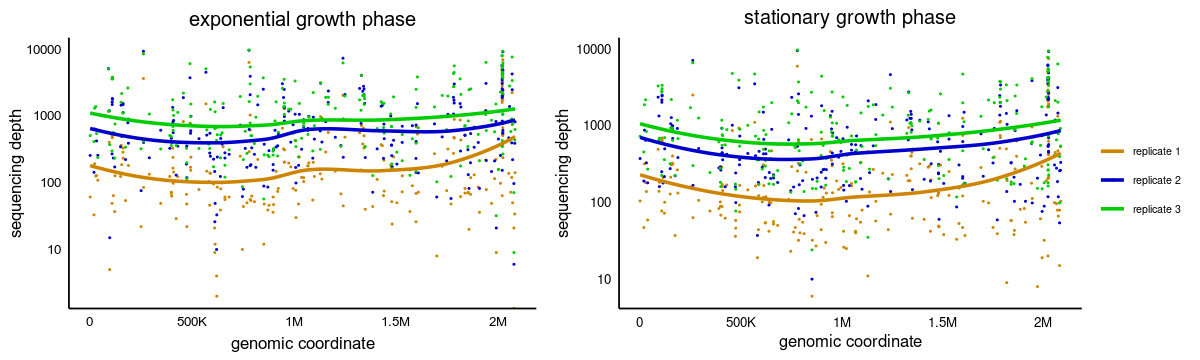

In [24]:
cov_e <- ggplot(data=cov_exoS_df, aes(x=TS559_position, y=value, color=variable))+
    geom_point(size=.2)+
    geom_smooth(se = F) +
    theme_classic() +
    scale_color_manual(values=c("orange3", "blue3","green3"))+
    labs(y='sequencing depth', x = 'genomic coordinate',title='exponential growth phase') +
    theme(text = element_text(size=10, family='arial', color='black'),
          axis.text = element_text(color='black'),
          axis.ticks = element_blank(),
         legend.position='none',
          plot.title = element_text(hjust = 0.5)
         ) +
  scale_y_continuous(trans = "log10")+
    scale_x_continuous(breaks = c(0,500000,1000000,1500000, 2000000), 
                       labels=c('0', '500K', '1M', '1.5M', '2M'))

cov_s <- ggplot(data=cov_statS_df, aes(x=TS559_position, y=value, color=variable))+
    geom_point(size=.2)+
    geom_smooth(se = F) +
    theme_classic() +
    scale_color_manual(values=c("orange3", "blue3","green3"))+
    labs(y='sequencing depth', x = 'genomic coordinate',title='stationary growth phase') +
    theme(text = element_text(size=10, color='black'),
          axis.ticks = element_blank(),
          axis.text = element_text(color='black'),
         legend.position='none',
         plot.title = element_text(hjust = 0.5)) +
      scale_y_continuous(trans = "log10") +
    scale_x_continuous(breaks = c(0,500000,1000000,1500000, 2000000), 
                       labels=c('0', '500K', '1M', '1.5M', '2M'))

options(repr.plot.width=10, repr.plot.height=3)

pp<- plot_grid(cov_e, cov_s, nrow=1, align='h')

plot_grid(pp, leg, nrow=1, rel_widths=c(2,.2))

ggsave('TS559_m5C_coverage.pdf',path='./figures/', device = cairo_pdf,  width=7, height=2, dpi = 600)


# how many high confidence, reproducible m5C sites detected in each growth phase?

In [28]:
"m5C sites exclusive to exoS:"
nrow((TS559_statSvsexoS %>% filter(exoS_reproducible == TRUE & statS_reproducible == FALSE)))
"m5C sites exclusive to statS:"
nrow((TS559_statSvsexoS %>% filter(statS_reproducible == TRUE & exoS_reproducible == FALSE)))
"m5C sites present in both exoS and statS:"
nrow((TS559_statSvsexoS %>% filter((statS_reproducible == TRUE & exoS_reproducible == TRUE))))
"total unique sites in either exoS and statS:"
nrow((TS559_statSvsexoS %>% filter((statS_reproducible == TRUE | exoS_reproducible == TRUE))))

[1] "m5C sites exclusive to exoS:"

[1] 108

[1] "m5C sites exclusive to statS:"

[1] 41

[1] "m5C sites present in both exoS and statS:"

[1] 83

[1] "total unique sites in either exoS and statS:"

[1] 232

In [ ]:
base_theme <- theme(
           text = element_text(size=10, family='arial', color='black'),
           plot.title = element_text(hjust = 0.5),
           axis.text.x = element_text(size = 10,color="black" ),
           axis.text.y = element_text(size = 10, color="black"),
           axis.ticks.x = element_line(color="black" ),
           axis.ticks.y = element_line(color="black"),
           axis.title = element_text( size = 10, color="black")
           
)


# High confidence thresholds

minimum coverage? \
minimum m5C count? \
minimum m5C frequency?

## power calculation

To make it easier, I am going to use a CGmap to calculate power, since all the numbers I will need will be in this dataframe anyway. We ultimately decided to apply a median effect size (h) of 0.5 to achieve a power of 0.8.

For a range of coverage, we will calculate power using:
pwr.p.test(h = 0.5, n = coverage, sig.level = 0.01)

Where h is 0.3, 0.5, or 0.8.

In [70]:
# generate "toy" data to calculate power value.

get_power <- function(cgmap){
    strain = unique(cgmap$strain)
    rep = unique(cgmap$replicate)
    
    data <- cgmap %>% 
        filter(coverage>0) %>%
        select(-trinuc_context, -dinuc_context) %>%
        distinct(coverage, .keep_all = TRUE)

    final_data <- data.frame(data) %>%
        rowwise() %>%
            # power using pwr package, one-sample t test with cohens d = 0.3, 0.5, or 0.8 
            # and sig level of 0.01
            mutate(power_3 = pwr.p.test(h = 0.3, n = coverage, sig.level = 0.01)$power ) %>%
            mutate(power_5 = pwr.p.test(h = 0.5, n = coverage, sig.level = 0.01)$power ) %>%
            mutate(power_8 = pwr.p.test(h = 0.8, n = coverage, sig.level = 0.01)$power ) %>%
        dplyr::rename(!!paste("coverage","_",strain,"_",rep, sep="") := coverage) %>%
        dplyr::rename(!!paste("mC_count","_",strain,"_",rep, sep="") := count_mC) %>%
        dplyr::rename(!!paste("methylation_frequency","_",strain,"_",rep, sep="") := methylation_frequency) %>%
        select(-replicate, -strain)
    
    return(final_data)
}


TS559exoS_power_calc <- get_power(TS559exoS_CGmap_rep3) %>%
    distinct(coverage_TS559_rep3, .keep_all = TRUE) %>%
    select(coverage_TS559_rep3, power_3, power_5, power_8) %>%
    dplyr::rename(coverage = coverage_TS559_rep3)

head(TS559exoS_power_calc)

coverage,power_3,power_5,power_8
<int>,<dbl>,<dbl>,<dbl>
1,0.01344295,0.02000446,0.0382485
102,0.67509358,0.99331808,1.0000000
108,0.70604327,0.99560768,1.0000000
114,0.73476679,0.99713381,1.0000000
116,0.74385290,0.99751781,1.0000000
117,0.74830548,0.99769070,1.0000000


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 8304 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 8304 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 8304 rows containing missing values (`geom_line()`).”


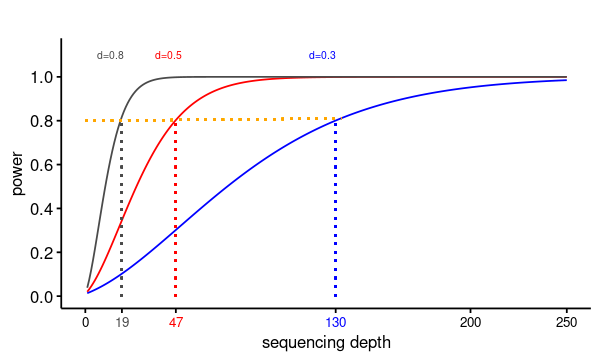

In [71]:
options(repr.plot.with = 6, repr.plot.height=3)

ggplot(TS559exoS_power_calc) +
    geom_line(aes(x=coverage, y = power_3),color='blue')+
    geom_line(aes(x=coverage, y = power_5),color='red')+
    geom_line(aes(x=coverage, y = power_8),color='grey29')+
    theme_classic()+
    scale_y_continuous(limits=c(0,1.12), breaks=c(0,.20,.40,.60,.80, 1.00))+
    scale_x_continuous(limits=c(0,250), breaks=c(0,19,47,130,200,250))+
    labs(y='power', x='sequencing depth', title='') +

    geom_segment(aes(x = 0, y = 0.8, xend = 133, yend = 0.81), 
                 linetype="dotted", color = 'orange',size=.6) +

    geom_segment(aes(x = 19, y = 0, xend = 19, yend = .8),
                 linetype = "dotted", col = "grey29", size=.6) +
        

    geom_segment(aes(x = 47, y = 0, xend = 47, yend = .8),
                 linetype = "dotted", col = "red", size=.6) +

    geom_segment(aes(x = 130, y = 0, xend = 130, yend = .8),
                 linetype = "dotted", col = "blue", size=.6) +

    annotate("text", x = 13, y = 1.1, label = 'd=0.8', color='grey29', size=2.2) +
    annotate("text", x = 43, y = 1.1, label = 'd=0.5', color='red', size=2.2) +
    annotate("text", x = 123, y = 1.1, label = 'd=0.3', color='blue', size=2.2) +

    theme(text = element_text(size=10, color='black'),
           plot.title = element_text(hjust = 0.5),
           axis.text.x = element_text(colour=c("black", "grey29", "red","blue","black")),
           axis.text.y = element_text(size = 10, color="black"),
           axis.ticks.x = element_line(color="black" ),
           axis.ticks.y = element_line(color="black"),
           axis.title = element_text( size = 10, color="black")  )

# Calculate the 99th percentile m5C coverage for entire library where cytidine coverage > 0 and total coverage >= 47

For each genomically encoded cytidine, there is a total coverage. But most if not all coverage at that position should be deaminated and sequenced as thymine. So even though a site may have 100x coverage, the cytidine coverage will likley be close to 0, and all nucleotides that map to that position will be thymines. There is a likely hood that any site may escape deamination and will retain a cytidine identity even though it is not actually methylated. To mitigate the rate of false positives, I will implement a parameter where the m5C coverage must meet some threshold. 1 or 2 cytidines retained at a position is not enough cytidine coverage to classify that cytidine as m5C. I will generate a list of cytidine coverage at each position, arrange in ascending order (automatically done by quantile() function), and calculate the 99th percentile minimum coverage. Since nearly all positions will be have a cytidine coverage of 0, this figure should be relatively low. For a high confidence m5C site to be called, the m5C coverage must meet the 99th percentile m5C coverage.  


In [57]:
# Good time to calculate the 99% m5C coverage for each library. 
# This number is the minimum m5C coverage for each high confidence m5C site. 
# I will only include sites with coverage >= 46
de1<- TS559exoS_rep1_df%>%filter(coverage_TS559_rep1>46, mC_count_TS559_rep1>=0)
de2<- TS559exoS_rep2_df%>%filter(coverage_TS559_rep2>46, mC_count_TS559_rep2>=0)
de3<- TS559exoS_rep3_df%>%filter(coverage_TS559_rep3>46, mC_count_TS559_rep3>=0)

ds1<- TS559statS_rep1_df%>%filter(coverage_TS559_rep1>46, mC_count_TS559_rep1>=0)
ds2<- TS559statS_rep2_df%>%filter(coverage_TS559_rep2>46, mC_count_TS559_rep2>=0)
ds3<- TS559statS_rep3_df%>%filter(coverage_TS559_rep3>46, mC_count_TS559_rep3>=0)


ci_e1 <- quantile(de1$mC_count_TS559_rep1, .99)
ci_e2 <- quantile(de2$mC_count_TS559_rep2, .99) 
ci_e3 <- quantile(de3$mC_count_TS559_rep3, .99) 

ci_s1 <- quantile(ds1$mC_count_TS559_rep1, .99) 
ci_s2 <- quantile(ds2$mC_count_TS559_rep2, .99) 
ci_s3 <- quantile(ds3$mC_count_TS559_rep3, .99)

"# m5C sites in 99% quantile"
data.frame(
strain = c('TS559'),
library = c("exoS", "exoS","exoS","statS","statS","statS"),
replicate = c(1,2,3),
" 99%" = c(ci_e1, ci_e2, ci_e3, ci_s1,ci_s2,ci_s3)    )

[1] "# m5C sites in 99% quantile"

strain,library,replicate,X.99.
<chr>,<chr>,<dbl>,<dbl>
TS559,exoS,1,6
TS559,exoS,2,18
TS559,exoS,3,7
TS559,statS,1,5
TS559,statS,2,17
TS559,statS,3,5


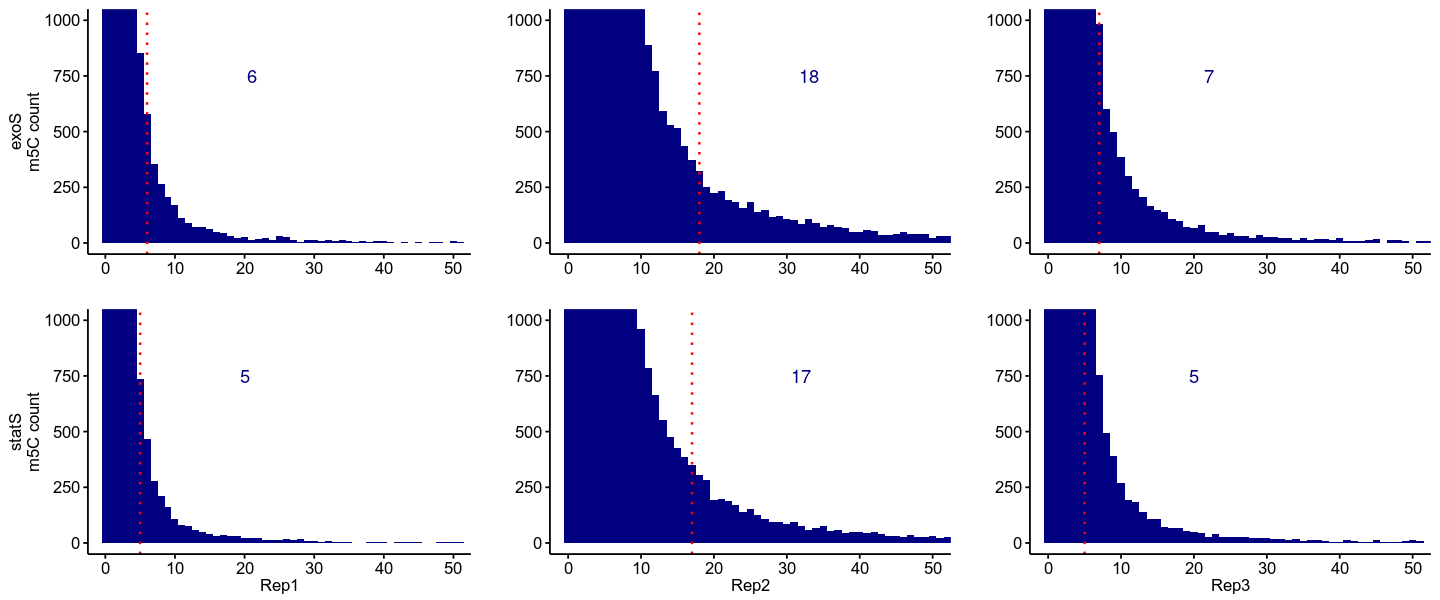

In [85]:
base_theme <-
    theme(
           text = element_text(size=10, family='arial', color='black'),
           plot.title = element_text(hjust = 0.5),
           axis.text.x = element_text(size = 10,color="black" ),
           axis.text.y = element_text(size = 10, color="black"),
           axis.ticks.x = element_line(color="black" ),
           axis.ticks.y = element_line(color="black"),
           axis.title = element_text( size = 10, color="black") )


h1<- ggplot(de1, aes(x=mC_count_TS559_rep1)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50), ylim=c(0,1000)) +
    labs(x='',y='exoS\nm5C count')+
    theme_classic() +
    geom_vline(xintercept = m5C_count_e1, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_e1+15, y = 750, label = m5C_count_e1, color='navy')+
    base_theme


h2<- ggplot(de2, aes(x=mC_count_TS559_rep2)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50),ylim=c(0,1000))+
    labs(x='',y='')+
    theme_classic()+
    geom_vline(xintercept = m5C_count_e2, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_e2+15, y = 750, label = m5C_count_e2, color='navy')+
    base_theme


h3<- ggplot(de3, aes(x=mC_count_TS559_rep3)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50),ylim=c(0,1000))+
    labs(x='',y='')+
    theme_classic()+
    geom_vline(xintercept = m5C_count_e3, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_e3+15, y = 750, label = m5C_count_e3, color='navy')+
    base_theme


h4<- ggplot(ds1, aes(x=mC_count_TS559_rep1)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50), ylim=c(0,1000)) +
    labs(x='Rep1',y='statS\nm5C count')+
    theme_classic()+
    geom_vline(xintercept = m5C_count_s1, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_s1+15, y = 750, label = m5C_count_s1, color='navy')+
    base_theme


h5<- ggplot(ds2, aes(x=mC_count_TS559_rep2)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50),ylim=c(0,1000))+
    labs(x='Rep2',y='')+
    theme_classic()+
    geom_vline(xintercept = m5C_count_s2, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_s2+15, y = 750, label = m5C_count_s2, color='navy')+
    base_theme


h6<- ggplot(ds3, aes(x=mC_count_TS559_rep3)) +
    geom_histogram(binwidth=1, fill="navyblue") +
    coord_cartesian(xlim=c(0,50),ylim=c(0,1000))+
    labs(x='Rep3',y='')+
    theme_classic()+
    geom_vline(xintercept = m5C_count_s3, size = 0.7, linetype=3, colour='red',alpha=1 )+
    annotate("text", x = m5C_count_s3+15, y = 750, label = m5C_count_s3, color='navy')+
    base_theme

options(repr.plot.width=12, repr.plot.height=5)
plot_grid(h1,h2,h3,h4,h5,h6, nrow=2)

ggsave('m5C_count_distribution.pdf', path='./figures/', device = cairo_pdf, width=6, height=3.2, dpi = 400)

The number of non-converted cytidines sequenced were enumerated over libraries from 2 growth phases (exoS, statS) and included 3 replicates. Relciates were then combined. A significant majority of Cytidines (>99%) were bisuflite converted. The number of non-converted cytidines withing the entirety of the library at a 99% confidence interval is illustrated (red line) and listed on each graph. The count of m5C-containing reads at a 99% CI likely represents the background non-conversion rate for that library. Graphs only depict a portion of the data where the max nuber of m5C as a specific count is 1000 and the observed m5C count is 100.

# What is the cytidine deamination rate for each representative library?

For a given CGmap, at every genomically encoded cytidine, there is provided a calculation of total coverage and cytidine coverage. I will divide the sum of all deaminated cytidine coverage by the sum of all coverage to get a library-wdie deamination rate. I will only include sites with coveage >= 47. 

In [74]:
# Caclulate the deamination rate of each sequenced library
e1<- 1-sum(TS559exoS_rep1_df$mC_count_TS559_rep1)/sum(TS559exoS_rep1_df$coverage_TS559_rep1)
e2<- 1-sum(TS559exoS_rep2_df$mC_count_TS559_rep2)/sum(TS559exoS_rep2_df$coverage_TS559_rep2)
e3<- 1-sum(TS559exoS_rep3_df$mC_count_TS559_rep3)/sum(TS559exoS_rep3_df$coverage_TS559_rep3)
s1<- 1-sum(TS559statS_rep1_df$mC_count_TS559_rep1)/sum(TS559statS_rep1_df$coverage_TS559_rep1)
s2<- 1-sum(TS559statS_rep2_df$mC_count_TS559_rep2)/sum(TS559statS_rep2_df$coverage_TS559_rep2)
s3<- 1-sum(TS559statS_rep3_df$mC_count_TS559_rep3)/sum(TS559statS_rep3_df$coverage_TS559_rep3)

data.frame(
library = c("exoS", "exoS", "exoS", "statS", "statS", "statS"),
replicate = c(1,2,3),
deamination_rate = c(e1,e2,e3,s1,s2,s3)
)

library,replicate,deamination_rate
<chr>,<dbl>,<dbl>
exoS,1,0.9978930
exoS,2,0.9976481
exoS,3,0.9990252
statS,1,0.9979420
statS,2,0.9975086
statS,3,0.9991312


In [75]:
#if combining replicates (total/pooled) just for fun

TS559exoS_int <-TS559exoS %>% rowwise() %>%
    mutate(mean_methylation_frequency = round(mean(c(methylation_frequency_TS559_rep1,
                                               methylation_frequency_TS559_rep2,
                                               methylation_frequency_TS559_rep3)),3) ) %>%
    mutate(total_m5C_count = mC_count_TS559_rep1 +
           mC_count_TS559_rep2 + mC_count_TS559_rep3) %>%
    
    mutate(total_coverage = coverage_TS559_rep1 +
           coverage_TS559_rep2 + coverage_TS559_rep3)%>%
    filter(total_coverage>46)


TS559statS_int <-TS559statS %>% rowwise() %>%
    mutate(mean_methylation_frequency = round(mean(c(methylation_frequency_TS559_rep1,
                                               methylation_frequency_TS559_rep2,
                                               methylation_frequency_TS559_rep3)),3) ) %>%
    mutate(total_m5C_count = mC_count_TS559_rep1 +
           mC_count_TS559_rep2 + mC_count_TS559_rep3) %>%
    
    mutate(total_coverage = coverage_TS559_rep1 +
           coverage_TS559_rep2 + coverage_TS559_rep3)%>%
    filter(total_coverage>46)

e_int<- 1-sum(TS559exoS_int$total_m5C_count,na.rm=TRUE) / sum(TS559exoS_int$total_coverage,na.rm=TRUE)
s_int<- 1-sum(TS559statS_int$total_m5C_count,na.rm=TRUE)/sum(TS559statS_int$total_coverage,na.rm=TRUE)
ci_e_int <- quantile(TS559exoS_int$total_m5C_count, .99, na.rm=TRUE) 
ci_s_int <- quantile(TS559statS_int$total_m5C_count, .99, na.rm=TRUE) 

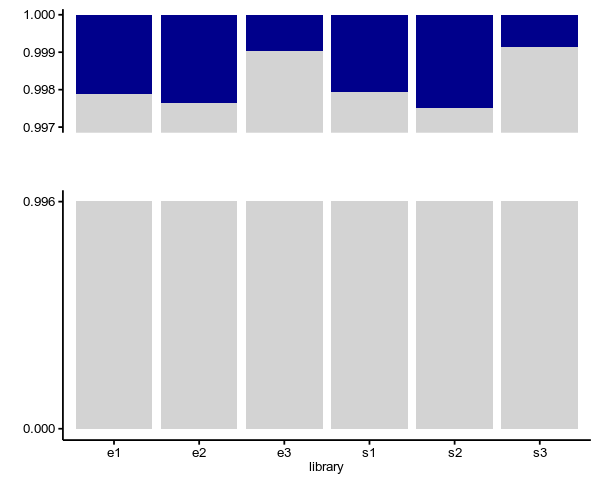

In [77]:
# manually populate dataframe because apparently it is too difficult to get it in the right format otherwise
labels <- c('e1','e2','e3','s1','s2','s3','e1','e2','e3','s1','s2','s3','exoS','exoS','statS','statS')
r <-c('cr','cr','cr','cr','cr','cr','ncr','ncr','ncr','ncr','ncr','ncr','cr','ncr','cr','ncr')
vals <- c(e1,e2,e3,s1,s2,s3,1-e1,1-e2,1-e3,1-s1,1-s2,1-s3,e_int,1-e_int,s_int,1-s_int)
group <-c('rep','rep','rep','rep','rep','rep','rep','rep','rep','rep','rep','rep','total','total','total','total')
cr_d <- data.frame(labels,vals,r,group) 
cr_d$r <- factor(cr_d$r, levels= c("ncr", "cr"))


g1 <- ggplot(cr_d%>%filter(group=='rep'), aes(x=labels, y=vals,fill=r)) +
    geom_bar(stat='identity') +
    theme_classic()+
    theme(legend.title = element_blank(),
          legend.position='none',
          
           text = element_text(size=8, family='arial', color='black'),
           plot.title = element_text(hjust = 0.5),
           axis.text.x = element_text(size = 8,color="black" ),
           axis.text.y = element_text(size = 8, color="black"),
           axis.ticks.x = element_line(color="black" ),
           axis.ticks.y = element_line(color="black"),
           axis.title = element_text( size = 8, color="black")
           )+
    scale_fill_manual(values=c('lightgray','lightgray')) +
    coord_cartesian(ylim=c(0.00,.996)) +
    labs(y='',x='library',title='')+
    scale_y_continuous(breaks = c(0,.996))

g1.1 <- ggplot(cr_d%>%filter(group=='rep'), aes(x=labels, y=vals,fill=r)) +
    geom_bar(stat='identity') +
    theme_classic()+
    theme(legend.title = element_blank(),
         axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
          legend.position='none',
          axis.line.x = element_blank(),
           text = element_text(size=8, family='arial', color='black'),
           plot.title = element_text(hjust = 0.5),
           axis.text.y = element_text(size = 8, color="black"),
           axis.ticks.y = element_line(color="black"),
           axis.title = element_text( size = 8, color="black")
           )+
    scale_fill_manual(values=c('blue4','lightgray')) +
    coord_cartesian(ylim=c(.997,1.0)) +
    labs(y='',x='')

options(repr.plot.width=5, repr.plot.height=4)

p <- plot_grid(g1.1,g1,nrow=2, align='v', rel_heights=c(.5,1))
p


ggsave('library_conversion_rates.pdf',path='./figures/', device = cairo_pdf,  width=2, height=2.3, dpi = 600)

# Determime what m5C frequency I should threshold at

It feels arbitrary to decide on a minimum m5C frequency without knowing what the m5C frequencies look like across the transcriptome prior to thresholding. 

Where total coverage is >= 47 and m5C coverage >= 99th percentile, I visualized via histogram m5C frequencies across the transcriptome for 6 representative libaries. It would appear that there are thousands of sites with m5C frequency bellow 2 or 3%. It is likely that these sites are false positives and are likely not true m5C sites. At ~10% modification frequency, there seems to be a leveling off of the number of m5C sites that meet a 10% m5C frequency. It is my best guess that sites at or greater than 10% are true m5C sites. For sites with extraordinarily high coverage (>= 1000), the m5C frequency threshold is lowered to 5% because these sites have a significantly high (>= 50x) m5C coverage. 


In [87]:
#query dataset for each library
f1 <- TS559exoS_all%>%filter(coverage_TS559_rep1>46, mC_count_TS559_rep1>m5C_count_e1)
f2 <- TS559exoS_all%>%filter(coverage_TS559_rep2>46, mC_count_TS559_rep1>m5C_count_e2)
f3 <- TS559exoS_all%>%filter(coverage_TS559_rep3>46, mC_count_TS559_rep1>m5C_count_e3)
f4 <- TS559statS_all%>%filter(coverage_TS559_rep1>46, mC_count_TS559_rep1>m5C_count_s1)
f5 <- TS559statS_all%>%filter(coverage_TS559_rep2>46, mC_count_TS559_rep1>m5C_count_s2)
f6 <- TS559statS_all%>%filter(coverage_TS559_rep3>46, mC_count_TS559_rep1>m5C_count_s3)

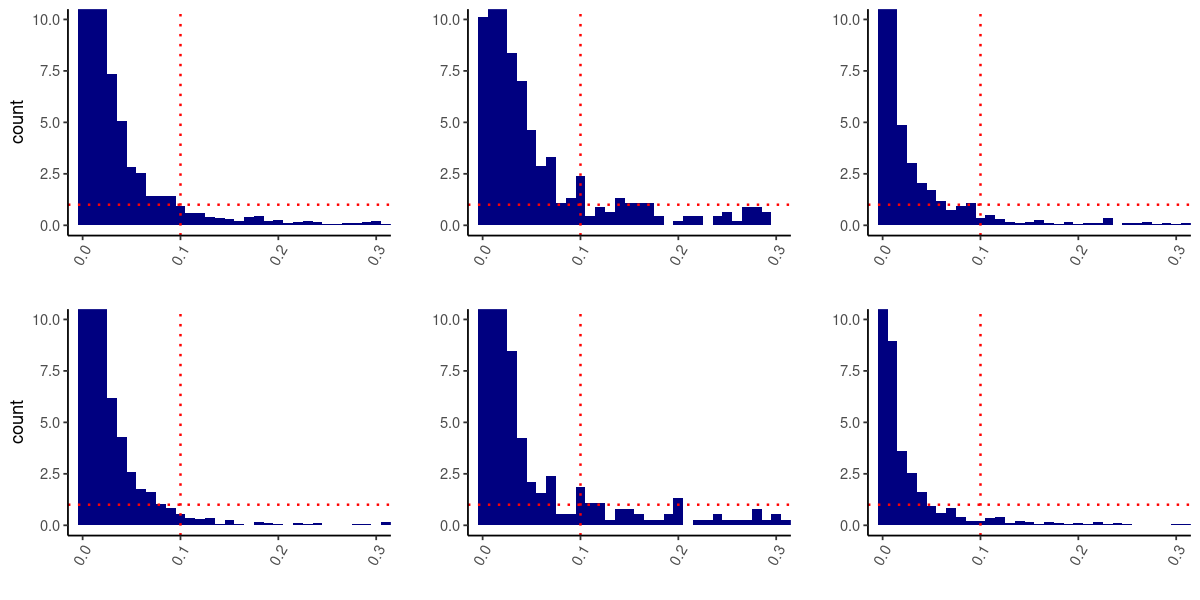

In [89]:
f1.1 <- ggplot(f1, aes(x=methylation_frequency_TS559_rep1)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='count',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 ) +
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f2.1 <- ggplot(f2, aes(x=methylation_frequency_TS559_rep2)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 )+
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f3.1 <- ggplot(f3, aes(x=methylation_frequency_TS559_rep3)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 ) +
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f4.1 <- ggplot(f4, aes(x=methylation_frequency_TS559_rep1)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='count',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 ) +
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f5.1 <- ggplot(f5, aes(x=methylation_frequency_TS559_rep2)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 ) +
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f6.1 <- ggplot(f6, aes(x=methylation_frequency_TS559_rep3)) +
     geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
     #geom_density(alpha=.3, fill="pink") +
    coord_cartesian(xlim=c(0,.3),ylim=c(0,10))+
    labs(y='',x='')+
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.text.x = element_text(angle=60, hjust=1))+
    scale_x_continuous(breaks=c(0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 )+
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )


options(repr.plot.width=10, repr.plot.height=5)
plot_grid(f1.1,f2.1,f3.1,f4.1,f5.1,f6.1,nrow=2)


The distribution of m5C frequencies at sites with 47x total coverage and m5C coverage at or above the 99% percentile. At approximately 10%, modification frequencies beging to level off, likely representing m5C frequencies above background. 

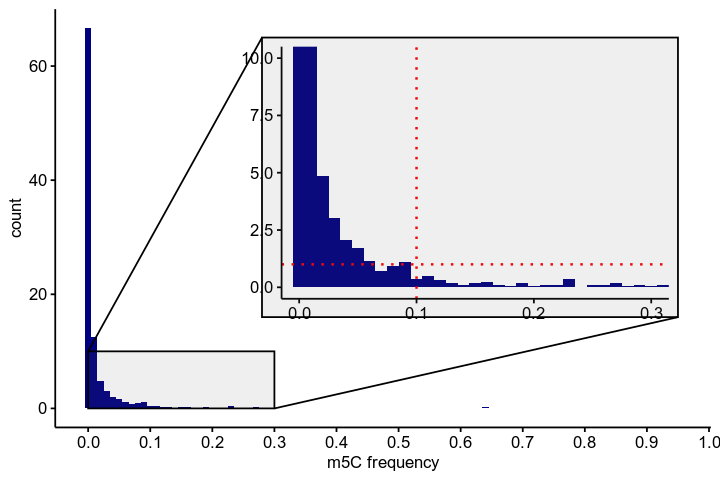

In [90]:
# representative figure

options(repr.plot.width=6, repr.plot.height=4)

f1.1.0 <- ggplot(f3, aes(x=methylation_frequency_TS559_rep3)) +
    geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
    coord_cartesian(xlim=c(0,.30),ylim=c(0,10))+
    labs(y='',x='')+
    theme_classic() +
        base_theme +

    scale_x_continuous(breaks=c(0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1.0))+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='red',alpha=1 ) +
    geom_vline(xintercept = .1, size = 0.7, linetype=3, colour='red',alpha=1 )



f1.1 <- ggplot(f3, aes(x=methylation_frequency_TS559_rep3)) +
    geom_histogram(aes(y=..density..), binwidth=.01, fill="navyblue") +
    labs(y='count',x='m5C frequency')+
    theme_classic() +
    base_theme +
    scale_x_continuous(breaks=c(0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1.0))+
    annotation_custom(ggplotGrob(f1.1.0), 
                      xmin = .20, xmax = .95, 
                      ymin = 10, ymax = 65) +
    
    annotate("rect", xmin = 0, xmax = .3, ymin = 0, ymax = 10, alpha = .1, color='black',fill='grey42') +
    annotate("rect", xmin = .28, xmax = .95, ymin = 16, ymax = 65, alpha = .1, color='black',fill='grey42')+
    
    annotate("segment", x = 0, xend = .28, y = 10, yend = 65, colour = "black")+
    annotate("segment", x = .30, xend = .95, y = 0, yend = 16, colour = "black")



f1.1
ggsave('m5C_frequency_distribution_exoS3.pdf', path='./figures/', device = cairo_pdf, width=3.5, height=3, dpi = 400)
#plot_grid(f1.1, f1.1.0, rel_widths=c(1,.5), rel_helghts=c(1,.5))

### final parameters for TS559 datasets

In [91]:
# minimum total coverage
coverage = 47

# minimum m5C coverage
m5C_count_e = 23
m5C_count_s = 19
m5C_count_e1 = 6
m5C_count_e2 = 18
m5C_count_e3 = 7
m5C_count_s1 = 5
m5C_count_s2 = 17
m5C_count_s3 = 5

# minimum m5C frequency
m5C_freq = 0.1

# Analysis of reproducibility -- Linear regression

In [100]:
# reproducible in >= 2/3 replicates

rsq <- function(x,y,sigfigs=2, method='pearson'){
    corcoef <- round(cor(x, y, method = c("pearson")),sigfigs)
    return(corcoef)
}
    
    
data_e12 = TS559exoS %>% 
    filter(reproducible == TRUE) 

r_e12 = paste("cor.coeff ",round(rsq(data_e12$methylation_frequency_TS559_rep1, 
                              data_e12$methylation_frequency_TS559_rep2),2))
data_e12_n <- paste('n=',nrow(data_e12), sep='')


data_e23 = TS559exoS %>% 
    filter(reproducible == TRUE) 

r_e23 = paste("cor.coeff ",round(rsq(data_e23$methylation_frequency_TS559_rep2, 
                              data_e23$methylation_frequency_TS559_rep3),2))
data_e23_n <- paste('n=',nrow(data_e23), sep='')


data_e13 = TS559exoS %>% 
    filter(reproducible == TRUE) 

r_e13 = paste("cor.coeff ",round(rsq(data_e23$methylation_frequency_TS559_rep1, data_e23$methylation_frequency_TS559_rep3),2))
data_e13_n <- paste('n=',nrow(data_e13), sep='')



data_s12 = TS559statS %>% 
    filter(reproducible == TRUE) 

r_s12 = paste("cor.coeff ",round(rsq(data_s12$methylation_frequency_TS559_rep1, data_s12$methylation_frequency_TS559_rep2),2))
data_s12_n <- paste('n=',nrow(data_s12), sep='')


data_s23 = TS559statS %>% 
    filter(reproducible == TRUE) 

r_s23 = paste("cor.coeff ",round(rsq(data_s23$methylation_frequency_TS559_rep2, data_s23$methylation_frequency_TS559_rep3),2))
data_s23_n <- paste('n=',nrow(data_s23), sep='')


data_s13 = TS559statS %>% 
    filter(reproducible == TRUE) 

r_s13 = paste("cor.coeff ",round(rsq(data_s23$methylation_frequency_TS559_rep1, data_s23$methylation_frequency_TS559_rep3),2))
data_s13_n <- paste('n=',nrow(data_s13), sep='')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing missing values (`geom_smooth()`).”


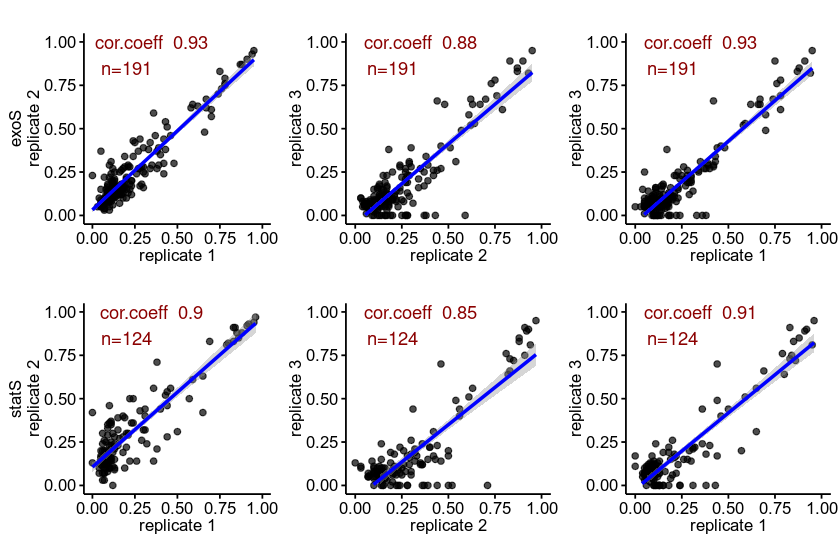

In [101]:
g1 <- ggplot(data_e12, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep2)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e12_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e12, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="exoS\nreplicate 2", title = '')

g2 <- ggplot(data_e23, 
                   aes(x=methylation_frequency_TS559_rep2, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e23_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e23, color='darkred') +
    base_theme +
    labs(x='replicate 2', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g3 <- ggplot(data_e13, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e13_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e13, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g4 <- ggplot(data_s12, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep2)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s12_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s12, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="statS\nreplicate 2", title = '')  #paste("R2=",round(rsq(x, y),3)))

g5 <- ggplot(data_s23, 
                   aes(x=methylation_frequency_TS559_rep2, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s23_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s23, color='darkred') +
    base_theme +
    labs(x='replicate 2', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g6 <- ggplot(data_s13, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s13_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s13, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


options(repr.plot.width=7, repr.plot.height=4.5)
plot_grid(g1, g2, g3, g4,g5,g6, nrow=2)

In [96]:
# reproducible in 3/3 replicates


rsq <- function(x,y,sigfigs=2, method='pearson'){
    
    corcoef <- round(cor(x, y, method = c("pearson")),sigfigs)
    return(corcoef)
}
    
    
data_e12 = TS559exoS %>% 
    filter(highly_reproducible == TRUE)

r_e12 = paste("cor.coeff ",round(rsq(data_e12$methylation_frequency_TS559_rep1, 
                              data_e12$methylation_frequency_TS559_rep2),2))
data_e12_n <- paste('n=',nrow(data_e12), sep='')


data_e23 = TS559exoS %>% 
    filter(highly_reproducible == TRUE)

r_e23 = paste("cor.coeff ",round(rsq(data_e23$methylation_frequency_TS559_rep2, 
                              data_e23$methylation_frequency_TS559_rep3),2))
data_e23_n <- paste('n=',nrow(data_e23), sep='')


data_e13 = TS559exoS %>% 
    filter(highly_reproducible == TRUE)

r_e13 = paste("cor.coeff ",round(rsq(data_e23$methylation_frequency_TS559_rep1, data_e23$methylation_frequency_TS559_rep3),2))
data_e13_n <- paste('n=',nrow(data_e13), sep='')



data_s12 = TS559statS %>% 
    filter(highly_reproducible == TRUE) 
r_s12 = paste("cor.coeff ",round(rsq(data_s12$methylation_frequency_TS559_rep1, data_s12$methylation_frequency_TS559_rep2),2))
data_s12_n <- paste('n=',nrow(data_s12), sep='')


data_s23 = TS559statS %>% 
    filter(highly_reproducible == TRUE) 

r_s23 = paste("cor.coeff ",round(rsq(data_s23$methylation_frequency_TS559_rep2, data_s23$methylation_frequency_TS559_rep3),2))
data_s23_n <- paste('n=',nrow(data_s23), sep='')


data_s13 = TS559statS %>% 
    filter(highly_reproducible == TRUE) 

r_s13 = paste("cor.coeff ",round(rsq(data_s23$methylation_frequency_TS559_rep1, data_s23$methylation_frequency_TS559_rep3),2))
data_s13_n <- paste('n=',nrow(data_s13), sep='')


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing missing values (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing missing values (`geom_smooth()`).”


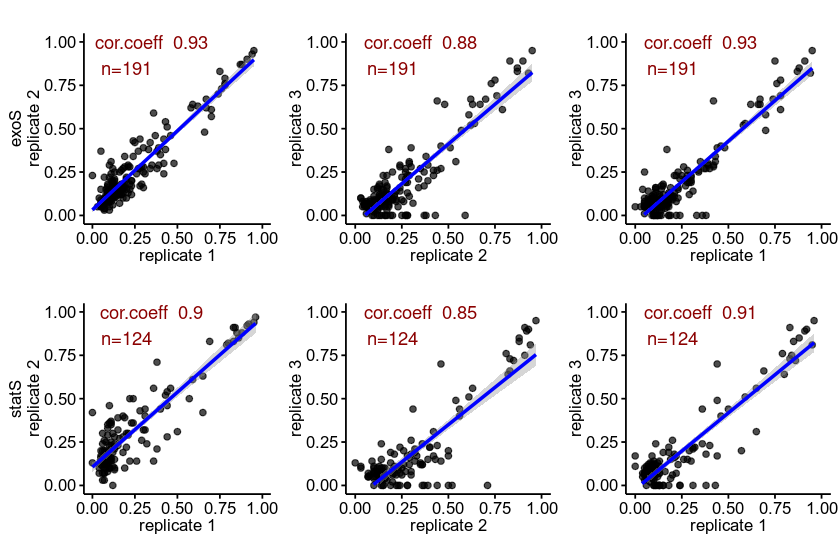

In [99]:
g1 <- ggplot(data_e12, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep2)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e12_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e12, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="exoS\nreplicate 2", title = '')

g2 <- ggplot(data_e23, 
                   aes(x=methylation_frequency_TS559_rep2, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e23_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e23, color='darkred') +
    base_theme +
    labs(x='replicate 2', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g3 <- ggplot(data_e13, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_e13_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_e13, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g4 <- ggplot(data_s12, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep2)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s12_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s12, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="statS\nreplicate 2", title = '')  #paste("R2=",round(rsq(x, y),3)))

g5 <- ggplot(data_s23, 
                   aes(x=methylation_frequency_TS559_rep2, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s23_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s23, color='darkred') +
    base_theme +
    labs(x='replicate 2', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


g6 <- ggplot(data_s13, 
                   aes(x=methylation_frequency_TS559_rep1, y=methylation_frequency_TS559_rep3)) +
    geom_point(alpha = 0.7,color = "black")+
    geom_smooth(method=lm, color="blue") +
    theme_classic() +
    scale_x_continuous(limits=c(0,1))+
    scale_y_continuous(limits=c(0,1))+
    annotate("text", x = .2, y = .85, label = data_s13_n, color='darkred') +
    annotate("text", x = .35, y = 1, label = r_s13, color='darkred') +
    base_theme +
    labs(x='replicate 1', y="replicate 3", title = '')  #paste("R2=",round(rsq(x, y),3)))


options(repr.plot.width=7, repr.plot.height=4.5)
plot_grid(g1, g2, g3, g4,g5,g6, nrow=2)

Linear regression of modification frequencies between replicates prepared from cultures grown to late stationary phase (statS) or early exponential phase (exoS). The number of observations are printed in red. Observations were included where sites had 47x coverage, non-converted Cytidine (m5C) coverage was at or above a 99% confidence interval for at least one library and the mean modification frequency was present at a rate of >= 1%. Pearsons correlation coefficients and number of observations for each comparision are included in red text. 

In [39]:
ggsave('TS559_3replicates_linear_regression.pdf', , device = cairo_pdf,
       path='./figures/', width=7, height=5, dpi = 400)

# Complete analysis of m5C sites in TS559

Unique methyl-5 Cytidine sites were detected in each replicate and across growth conditions. Number of methylation sites in replicates 1-3 from cells grown to exponential (exoS) or stationary (statS) growth phase were individually enuemrated. When samples were pooled, 269 m5C sites where detected (data not shown). A total of 181 m5C sites were confidently called in at least two repicates, and 83 unique sites were called in all three replicates.

## positional distribution within mRNA

In [129]:
enrichment_position <- function(dataframe, num_bins=30, ylabel, t){
    
    base_theme <- theme(
          axis.line.x=element_blank(), 
          axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
        
          plot.title = element_text(hjust = 0.5) )
    dataframe$percent_position_in_transcript <- as.double(dataframe$percent_position_in_transcript)
    
    g <- ggplot(dataframe%>%filter(element_type == 'mRNA'), 
        aes(x=percent_position_in_transcript)) + 
    geom_histogram(aes(y= ..density..), bins=num_bins, fill="blue3",color='blue3')+
    geom_density(color = "black", fill='pink', alpha = .3) +
    theme_classic() +
    labs(x='', y=ylabel, title = t) +
    base_theme
    
    return(g)
}


Warning message in enrichment_position(TS559exoS %>% filter(reproducible == TRUE), :
“NAs introduced by coercion”
Warning message in enrichment_position(TS559statS %>% filter(reproducible == TRUE), :
“NAs introduced by coercion”
Warning message in enrichment_position(TS559exoS %>% filter(highly_reproducible == :
“NAs introduced by coercion”


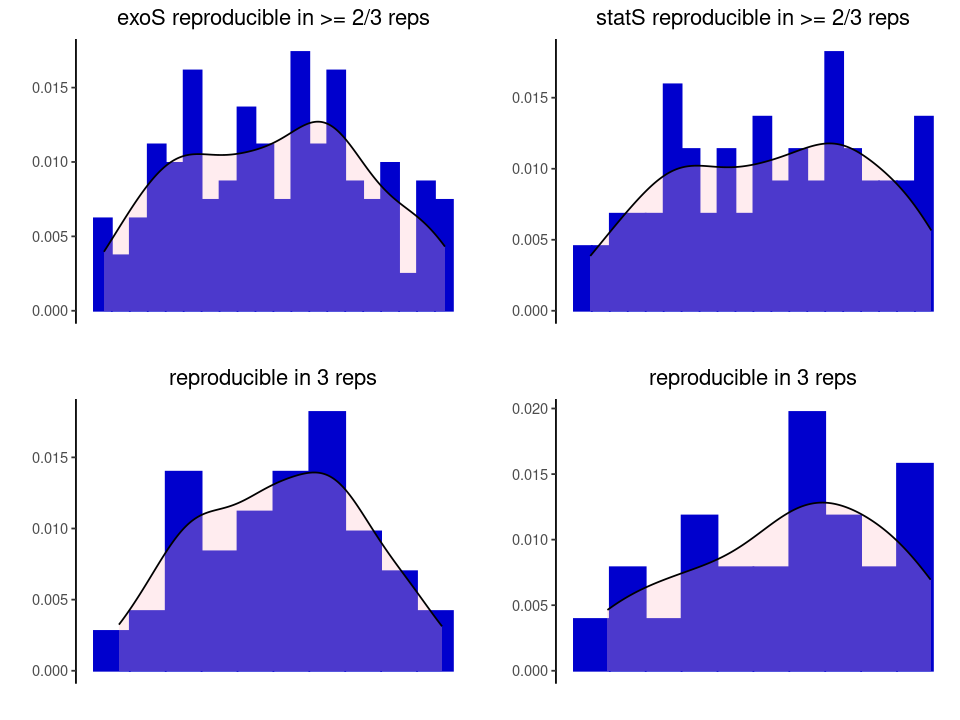

In [137]:
g7 <- enrichment_position(TS559exoS%>%filter(reproducible==TRUE), 
                          num_bins=20, ylabel="", t='exoS reproducible in >= 2/3 reps')
g8 <- enrichment_position(TS559statS%>%filter(reproducible==TRUE), 
                          num_bins=20, ylabel="", t='statS reproducible in >= 2/3 reps')

g9 <- enrichment_position(TS559exoS%>%filter(highly_reproducible==TRUE), 
                          num_bins=10, ylabel="", t='reproducible in 3 reps')
g10 <- enrichment_position(TS559statS%>%filter(highly_reproducible==TRUE), 
                           num_bins=10, ylabel="", t='reproducible in 3 reps')



options(repr.plot.width=8, repr.plot.height=6)
plot_grid(g7,g8,g9,g10,nrow=2)

#ggsave('m5C_gene_distribution_reproducible.pdf', path='./figures/', width=12, height=7, dpi = 200)


The relative position in the RNA for each high confidence m5C sites was mapped, and the data suggests that m5C is enriched in open reading frames of mRNAs. Indivdual replicates and combined libraries are illustrated.

## Modification frequencies within each class of RNA

In [146]:
#set factor levels for RNA class
levels <- c('mRNA',"3'UTR","5'UTR",'antisense-mRNA',
            'likely_processed_region','tRNA','rRNA','antisense-rRNA', 'RNaseP', 'ncRNA')

In [147]:
levels_bx <- c('mRNA',"3'UTR","5'UTR",'a-mRNA',
            'likely_processed_region','tRNA','rRNA','a-rRNA', 'RNaseP', 'ncRNA')

In [141]:
draw_boxplot <- function(data, month, ylab='', xlab=''){
    if(month=='March'){
    g <- ggplot(data%>%filter(element_type!='NA'), 
       aes(y=methylation_frequency_TS559_March2016, x=element_type)) +
    geom_boxplot() +
    geom_jitter(shape=16, position=position_jitter(0.2)) +
    theme_classic() +
    labs(y=ylab, x=xlab)+
    theme(
    axis.text.x = element_text(angle=45, hjust=1,color='black'),
    axis.text.y = element_text(color='black')
    
    )+
    scale_y_continuous(limits=c(0,1.0))
    }
    
    
    if(month=='Dec'){g <- ggplot(data%>%filter(element_type!='NA'), 
       aes(y=methylation_frequency_TS559_Dec2016, x=element_type)) +
    geom_boxplot() +
    geom_jitter(shape=16, position=position_jitter(0.2)) +
    theme_classic() +
    labs(y=ylab, x=xlab)+
    theme(
    axis.text.x = element_text(angle=45, hjust=1,color='black'),
    axis.text.y = element_text(color='black')
    
    )+
    scale_y_continuous(limits=c(0,1.0))
                    }
    if(month=='Oct'){g <- ggplot(data%>%filter(element_type!='NA'), 
       aes(y=methylation_frequency_TS559_Oct2020, x=element_type)) +
    geom_boxplot() +
    geom_jitter(shape=16, position=position_jitter(0.2)) +
    theme_classic() +
    labs(y=ylab, x=xlab)+
    theme(
    axis.text.x = element_text(angle=45, hjust=1,color='black'),
    axis.text.y = element_text(color='black')
    
    )+
    scale_y_continuous(limits=c(0,1.0))
                    }
    return(g)
    
    }



In [149]:
# wrangle the data
bx_r_e <- TS559_statSvsexoS %>% 
    filter(exoS_reproducible == TRUE, element_type!='likely_processed_region') %>% 
    filter(element_type!='NA') %>%
    mutate(phase='exponential growth') %>%
    mutate(mean_methylation_frequency = exoS_mean_methylation_frequency) %>%
    select(TS559_position,phase, element_type,mean_methylation_frequency) %>%
    rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))


bx_r_s <- TS559_statSvsexoS %>% 
    filter(statS_reproducible == TRUE, element_type!='likely_processed_region') %>% 
    filter(element_type!='NA') %>%
    mutate(phase = 'stationary growth')%>%
    mutate(mean_methylation_frequency = statS_mean_methylation_frequency) %>%
    select(TS559_position,phase, element_type,mean_methylation_frequency)%>%
    rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))


bx_r$element_type <- factor(bx_r$element_type, levels = levels_bx)

bx_hr_e <- TS559_statSvsexoS %>% 
    filter(exoS_highly_reproducible == TRUE, element_type!='likely_processed_region') %>%
    filter(element_type!='NA') %>%
    mutate(phase='exponential growth') %>%
    mutate(mean_methylation_frequency = exoS_mean_methylation_frequency) %>%
    select(TS559_position,phase, element_type,mean_methylation_frequency) %>%
    rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))


bx_hr_s <- TS559_statSvsexoS %>% 
    filter(statS_highly_reproducible == TRUE) %>%
    filter(element_type!='NA', element_type!='likely_processed_region') %>%
    mutate(phase = 'stationary growth')%>%
    mutate(mean_methylation_frequency = statS_mean_methylation_frequency) %>%
    select(TS559_position,phase, element_type,mean_methylation_frequency)%>%
    rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))


bx_hr <- rbind(bx_hr_e,bx_hr_s)
bx_hr$element_type <- factor(bx_hr$element_type, levels = levels_bx)



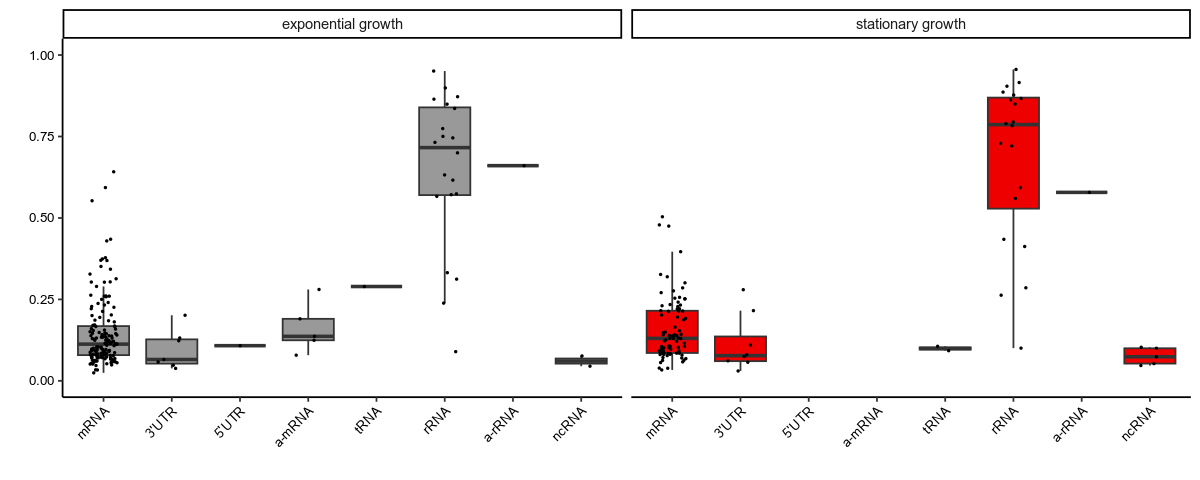

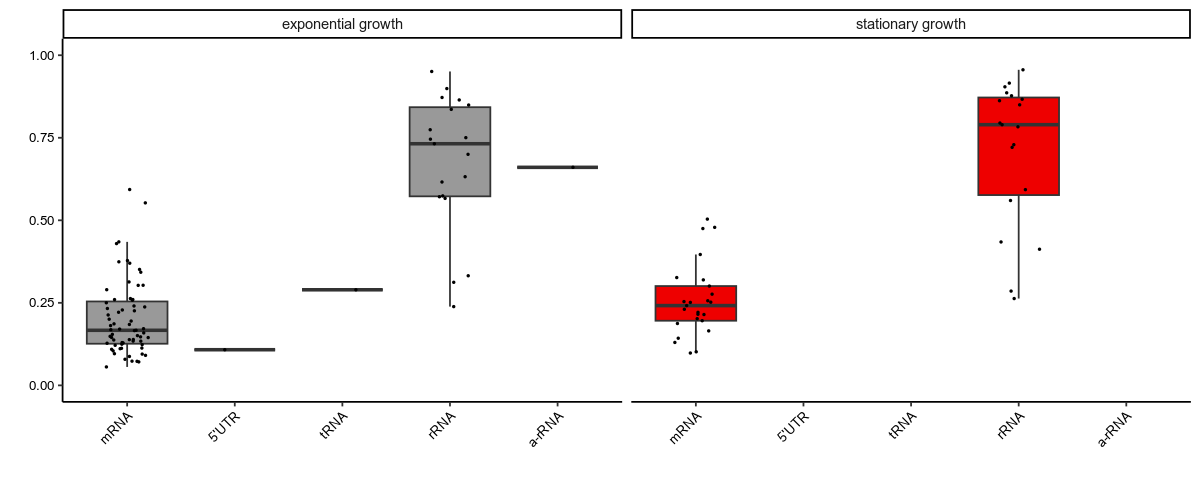

In [144]:
b7 <- ggplot(bx_r, 
       aes(y=mean_methylation_frequency, x=element_type) )+
    geom_boxplot(aes(fill=phase), outlier.shape = NA) +
    geom_jitter(position=position_jitter(0.2), size = 0.3) +
    theme_classic() +
    labs(x="", y="")+
    theme(text = element_text(family = 'arial'),
        axis.text.x = element_text(angle=45, hjust=1,size = 8, color='black', family = 'arial'),
        axis.text.y = element_text(color='black', size = 8, family = 'arial'),
        legend.position = "none") +
    facet_wrap(~phase) +
    scale_y_continuous(limits=c(0,1.0)) +
    scale_fill_manual(values=c("#999999", "red2"))

options(repr.plot.width=10, repr.plot.height=4)

b7
ggsave('m5C_frequency_distribution_reproducible.pdf', 
       path='./figures/', 
       device = cairo_pdf, width=4, height=3, dpi = 200)


b72 <- ggplot(bx_hr,
       aes(y=mean_methylation_frequency, x=element_type) )+
    geom_boxplot(aes(fill=phase), outlier.shape = NA) +
    geom_jitter(position=position_jitter(0.2), size = 0.3) +
    theme_classic() +
    labs(x="", y="")+
    theme( text = element_text(family = 'arial'),
        axis.text.x = element_text(angle=45, hjust=1,size = 8, color='black', family = 'arial'),
        axis.text.y = element_text(color='black', size = 8, family = 'arial'),
        legend.position = 'none') +
    facet_wrap(~phase) +
    scale_y_continuous(limits=c(0,1.0)) +
    scale_fill_manual(values=c("#999999", "red2"))

b72
ggsave('m5C_frequency_distribution_highly_reproducible.pdf', 
       device = cairo_pdf, path='./figures/', 
       width=4, height=3, dpi = 200)


Modification frequencies in >= 2/3 (top) or all 3 (bottom) replicates are illustrated here.

## Logos seqence analysis

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>.”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


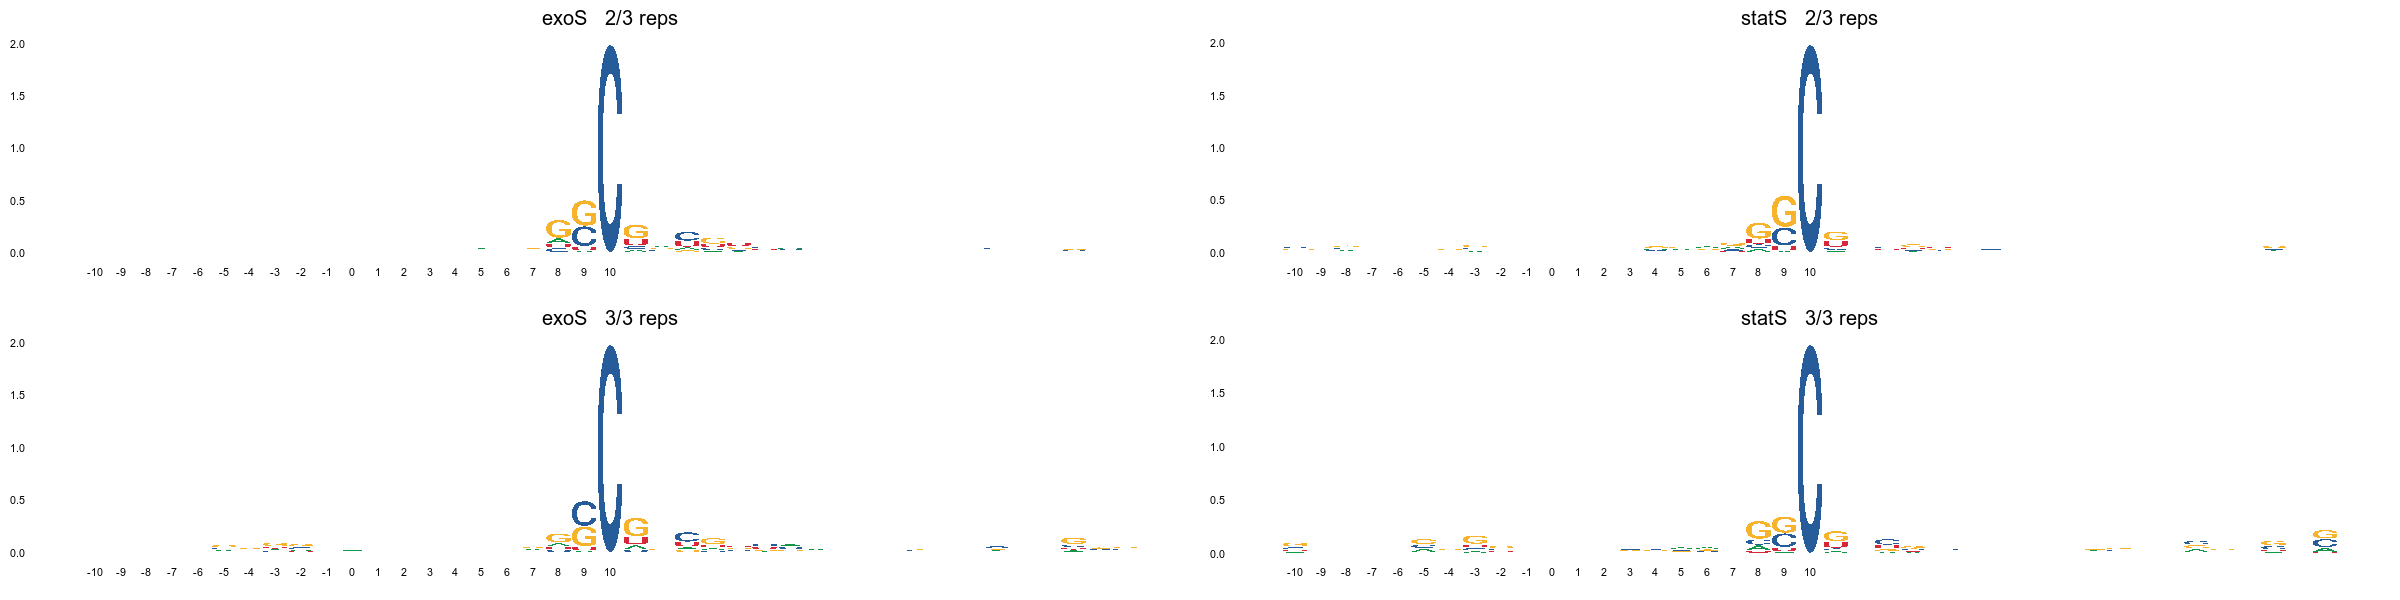

In [150]:
ere_logos<- TS559exoS %>% filter(logos_sequence_41bp != 'NA', reproducible==TRUE)
ehire_logos<- TS559exoS %>% filter(logos_sequence_41bp != 'NA', highly_reproducible==TRUE)


sre_logos<- TS559statS %>% filter(logos_sequence_41bp != 'NA', reproducible==TRUE)
shire_logos<- TS559statS %>% filter(logos_sequence_41bp != 'NA', highly_reproducible==TRUE)


logos1 <- ggplot() + 
    geom_logo(ere_logos$logos_sequence_41bp, method='bit' ) + 
    theme_logo() +
    labs(title = 'exoS   2/3 reps') +
    theme(plot.title = element_text(size=12,hjust = 0.5),
         axis.title.y = element_blank(),
         text = element_text(size = 8, family='arial')) +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),
        labels = c(-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10))

logos2 <- ggplot() + 
    geom_logo(ehire_logos$logos_sequence_41bp, method='bit' ) + 
    theme_logo() +
    labs(title = 'exoS   3/3 reps', y='') +
    theme(plot.title = element_text(size=12,hjust = 0.5),
         axis.title.y = element_blank(),
         text = element_text(size = 8, family='arial')) +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),
        labels = c(-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10))


logos3 <- ggplot() + 
    geom_logo(sre_logos$logos_sequence_41bp, method='bit' ) + 
    theme_logo() +
    labs(title = 'statS   2/3 reps') +
    theme(plot.title = element_text(size=12,hjust = 0.5),
         axis.title.y = element_blank(),
         text = element_text(size = 8, family='arial')) +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),
        labels = c(-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10))

logos4 <- ggplot() + 
    geom_logo(shire_logos$logos_sequence_41bp, method='bit' ) + 
    theme_logo() +
    labs(title = 'statS   3/3 reps', y='') +
    theme(plot.title = element_text(size=12,hjust = 0.5),
         axis.title.y = element_blank(),
         text = element_text(size = 8, family='arial')
         
         ) +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21),
        labels = c(-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10))

options(repr.plot.width=20, repr.plot.height=5)


plot_grid(logos1,logos3,logos2,logos4, nrow=2)

ggsave('TS559_logos_plots.pdf', path='./figures/', 
       device = cairo_pdf, width=5,height=2.5, dpi = 200)


## number of m5C sites that are reproducible in >= 2/3 or all 3 replicates

In [152]:
# number sites exoS vs statS
sites <- TS559_statSvsexoS
"total sites reproducible"
nrow(sites)

sites_es <- TS559_statSvsexoS %>% filter(exoS_reproducible == TRUE & statS_reproducible == TRUE)
"total sites exoS + statS reproducible"
nrow(sites_es)


sites_e <- TS559_statSvsexoS %>% filter(exoS_reproducible == TRUE & statS_reproducible == FALSE)
"total sites exoS only reproducible"
nrow(sites_e)


sites_s <- TS559_statSvsexoS %>% filter(exoS_reproducible == FALSE & statS_reproducible == TRUE)
"total sites statS only reproducible"
nrow(sites_s)



hrsites <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == TRUE | statS_highly_reproducible == TRUE)
"total sites highly reproducible"
nrow(hrsites)

hrsites_es <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == TRUE & statS_highly_reproducible == TRUE)
"total sites exoS + statS highly reproducible"
nrow(hrsites_es)


hrsites_e <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == TRUE & statS_highly_reproducible == FALSE)
"total sites exoS only highly reproducible"
nrow(hrsites_e)


hrsites_s <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == FALSE & statS_highly_reproducible == TRUE)
"total sites statS only highly reproducible"
nrow(hrsites_s)

[1] "total sites reproducible"

[1] 232

[1] "total sites exoS + statS reproducible"

[1] 83

[1] "total sites exoS only reproducible"

[1] 108

[1] "total sites statS only reproducible"

[1] 41

[1] "total sites highly reproducible"

[1] 99

[1] "total sites exoS + statS highly reproducible"

[1] 34

[1] "total sites exoS only highly reproducible"

[1] 55

[1] "total sites statS only highly reproducible"

[1] 10

In [153]:
# number unique transcripts exoS vs statS


ut <- TS559_statSvsexoS %>% distinct(element_name)
"total unique transcripts reproducible"
nrow(ut)


ut_es <- TS559_statSvsexoS %>% filter(exoS_reproducible == TRUE & statS_reproducible == TRUE)%>% distinct(element_name)
"total unique transcripts exoS + statS reproducible"
nrow(ut_es)


ut_e <- TS559_statSvsexoS %>% filter(exoS_reproducible == TRUE & statS_reproducible == FALSE)%>% distinct(element_name)
"total unique transcripts exoS only reproducible"
nrow(ut_e)


ut_s <- TS559_statSvsexoS %>% filter(exoS_reproducible == FALSE & statS_reproducible == TRUE)%>% distinct(element_name)
"total unique transcripts statS only reproducible"
nrow(ut_s)





hrut <- TS559_statSvsexoS %>%
    filter(exoS_highly_reproducible == TRUE | statS_highly_reproducible == TRUE) %>% 
    distinct(element_name)
"total unique transcripts highly reproducible"
nrow(hrut)


hrut_es <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == TRUE & statS_highly_reproducible == TRUE)%>% 
    distinct(element_name)
"total unique transcripts exoS + statS highly reproducible"
nrow(hrut_es)


hrut_e <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == TRUE & statS_highly_reproducible == FALSE)%>% 
    distinct(element_name)
"total unique transcripts exoS only highly reproducible"
nrow(hrut_e)


hrut_s <- TS559_statSvsexoS %>% filter(exoS_highly_reproducible == FALSE & statS_highly_reproducible == TRUE)%>% 
    distinct(element_name)
"total unique transcripts statS only highly reproducible"
nrow(hrut_s)


[1] "total unique transcripts reproducible"

[1] 188

[1] "total unique transcripts exoS + statS reproducible"

[1] 64

[1] "total unique transcripts exoS only reproducible"

[1] 98

[1] "total unique transcripts statS only reproducible"

[1] 40

[1] "total unique transcripts highly reproducible"

[1] 77

[1] "total unique transcripts exoS + statS highly reproducible"

[1] 16

[1] "total unique transcripts exoS only highly reproducible"

[1] 53

[1] "total unique transcripts statS only highly reproducible"

[1] 10

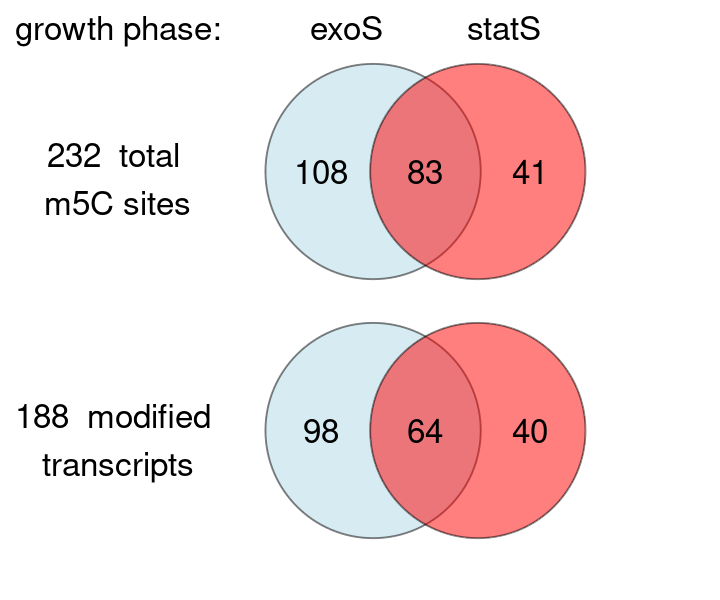

In [154]:
X=c(-4,4)
Y=c(3,3)
group = c('x','y')
df <- data.frame(X,Y, group)
df.group <- as.factor(df$group)

p1<- ggplot(df,aes(x=X, y=Y)) +
geom_point(aes(fill=group),alpha=.5, colour="black",pch=21, size=60, stroke=.8) +
    theme_void() +
    scale_y_continuous(limits=c(-5,14)) +
    scale_x_continuous(limits=c(-30,20))+
    theme(text = element_text(size=10, family='arial'),legend.position="none") +
    scale_fill_manual(values=c("lightblue","red")) +

annotate("text", x = -8, y = 3, label = nrow(sites_e), size =7) +
annotate("text", x = 8, y = 3, label = nrow(sites_s), size =7) +
annotate("text", x = 0, y = 3, label = nrow(sites_es), size =7) +
annotate("text", x =-23.5, y = 2.5, label = paste(nrow(sites)," total 
m5C sites"), size =7) +
annotate("text", x =-23.5, y = 13, label = "growth phase:", size =7) +
annotate("text", x = -6, y = 13, label = 'exoS', size =7) +
annotate("text", x = 6, y = 13, label = 'statS', size =7)



p2 <- ggplot(df,aes(x=X, y=Y)) +
geom_point(aes(fill=group),alpha=.5, colour="black",pch=21, size=60, stroke=.8) +
    theme_void() +
    scale_y_continuous(limits=c(-5,9)) +
    scale_x_continuous(limits=c(-30,20))+
    theme(text = element_text(size=10, family='arial'),legend.position="none") +
    scale_fill_manual(values=c("lightblue","red")) +

annotate("text", x = -8, y = 3, label = nrow(ut_e), size =7) +
annotate("text", x = 8, y = 3, label = nrow(ut_s), size =7) +
annotate("text", x = 0, y = 3, label = nrow(ut_es), size =7) +
annotate("text", x =-23.5, y = 2.5, label = paste(nrow(ut)," modified 
transcripts"), size =7)


options(repr.plot.width=6, repr.plot.height=5)

plot_grid(p1,p2,ncol=1)

ggsave('TS559_sites_and transcripts_breakdown.pdf', path='./figures/', width=6, height=5, dpi = 200)



## # m5C sites by RNA type and reproducibility level

In [156]:
#dff_r$element_type

fc_levels <- c('mRNA',"3'UTR","5'UTR",'a-mRNA',
            'likely_processed_region','ncRNA','tRNA','rRNA','a-rRNA')

In [157]:
dff_r <- TS559_statSvsexoS %>%
    group_by(element_type) %>%
    summarize(n=n())%>%
rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))

dff_r$element_type <- factor(dff_r$element_type, levels = fc_levels)

dff_r <- dff_r %>% filter(element_type != 'likely_processed_region')


"reproducible"
dff_r
sum(dff_r$n)



dff_hr <- TS559_statSvsexoS %>%
    filter(exoS_highly_reproducible == TRUE | statS_highly_reproducible == TRUE) %>%
    group_by(element_type) %>%
    summarize(n=n())%>%
rowwise() %>%
    mutate(element_type = str_replace(element_type, 'antisense', 'a'))

dff_hr$element_type <- factor(dff_hr$element_type, levels = fc_levels)

"highly reproducible"
dff_hr
sum(dff_hr$n)


[1] "reproducible"

element_type,n
<fct>,<int>
3'UTR,11
5'UTR,1
a-mRNA,5
a-rRNA,1
mRNA,185
ncRNA,5
rRNA,20
tRNA,2


[1] 230

[1] "highly reproducible"

element_type,n
<fct>,<int>
5'UTR,1
a-rRNA,1
mRNA,77
rRNA,19
tRNA,1


[1] 99

element_type,n
<fct>,<int>
5'UTR,1
a-rRNA,1
mRNA,77
rRNA,19
tRNA,1


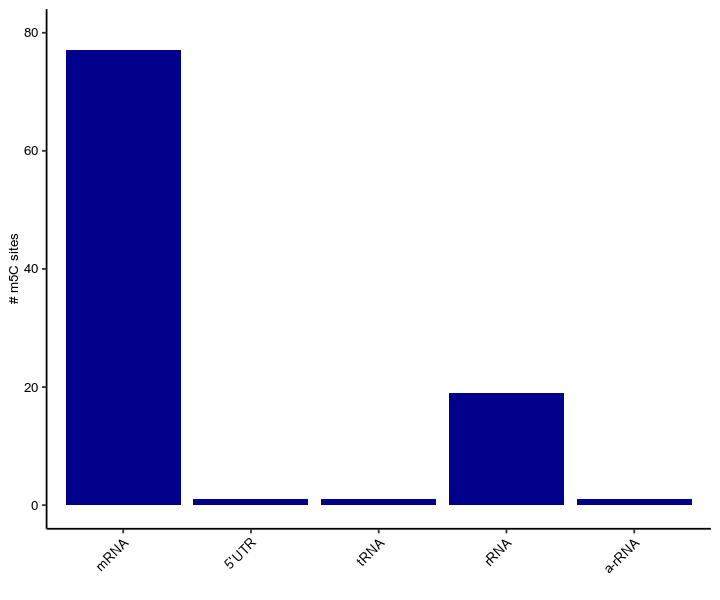

In [158]:
b000 <- ggplot(dff_hr, aes(x=element_type, y = n) )+
    geom_bar( stat="identity", fill = "blue4")+
    theme_classic()+
    scale_y_continuous(limits = c(0,80)) +
    labs(y='# m5C sites', x='') +
    theme(
        axis.text = element_text(size=8, color = 'black', family='arial'),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(size=8, color = 'black', family='arial')

       )

b000

ggsave('TS559_transcript_type_bargraph_highly_reproducible.pdf', path='./figures/', device = cairo_pdf, 
       width=2, height=2, dpi = 200)

dff_hr

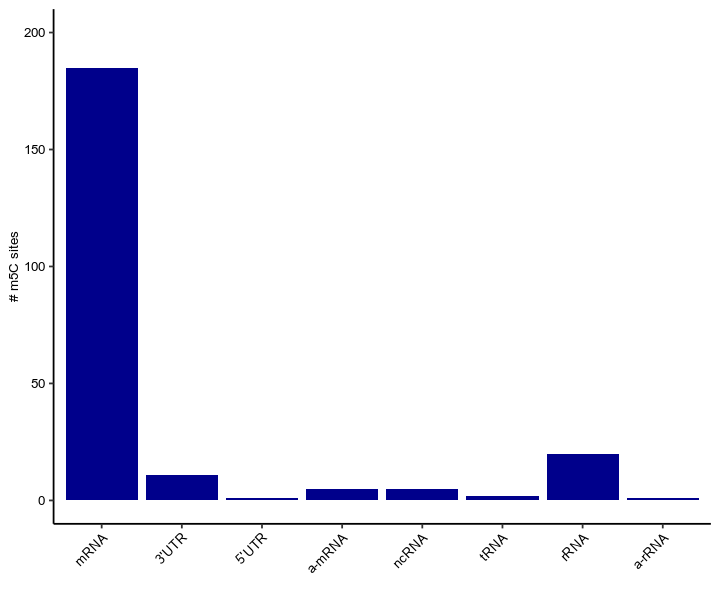

In [159]:

b00<- ggplot(dff_r, aes(x=element_type, y = n) )+
    geom_bar( stat="identity", fill = "blue4")+
    theme_classic()+
    scale_y_continuous(limits = c(0,200)) +
    labs(y='# m5C sites', x='') +
    theme(
        axis.text = element_text(size=8, color = 'black', family='arial'),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_text(size=8, color = 'black', family='arial')

       )


ggsave('TS559_transcript_type_bargraph_reproducible.pdf', path='./figures/', device = cairo_pdf, 
       width=2.5, height=2.5, dpi = 200)

b00

## mRNA region enrichment

In [162]:
labels <- c("5'UTR", "CDS", "3'UTR")
deviation_reproducible <- data.frame(labels, 
                                     phase = c("exoS","exoS","exoS","statS","statS","statS" ),
                                     values = c(0.38, 0.96, 2.24,1, 1.13, 4.41))

deviation_reproducible$labels <- factor(deviation_reproducible$labels, levels = labels)

deviation_HR <- data.frame(labels, 
                           phase = c("exoS","exoS","exoS","statS","statS","statS" ),
                           values = c(0.9, 1.08, 0, 0,1.04,0))

deviation_HR$labels <- factor(deviation_HR$labels, levels = labels)


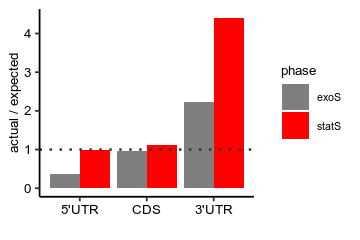

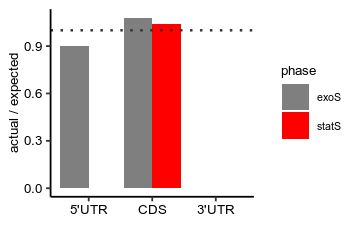

In [163]:
options(repr.plot.width = 3, repr.plot.height = 2)

ggplot(deviation_reproducible, aes(x=labels, y = values,fill=phase)) +
    geom_bar(stat="identity",position = position_dodge()) +
    theme_classic()+
    scale_fill_manual(values = c("grey50", "red")) +
    labs(y = "actual / expected", x='')+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='grey20',alpha=1 ) +
    theme(text = element_text(size=8, family='arial'),
          axis.text.x = element_text(color='black', size=8),
          axis.text.y = element_text(color='black', size=8) )

ggsave('TS559_mRNA_enrichment_position.pdf', device = cairo_pdf, path='./figures/', 
       width=3, height=2, dpi = 200)


ggplot(deviation_HR, aes(x=labels, y = values,fill=phase)) +
    geom_bar(stat="identity",position = position_dodge()) +
    theme_classic()+
    scale_fill_manual(values = c("grey50", "red")) +
    labs(y = "actual / expected", x='')+
    geom_hline(yintercept = 1, size = 0.7, linetype=3, colour='grey20',alpha=1 ) +
    theme(text = element_text(size=8, family='arial'),
          axis.text.x = element_text(color='black', size=8),
          axis.text.y = element_text(color='black', size=8) )

ggsave('TS559_mRNA_enrichment_position_highly_reproducible.pdf', device = cairo_pdf, path='./figures/', 
       width=3, height=2, dpi = 200)

## amino acid/codon context

For simplicity, analysis for highly reproducible (3/3 replicates) is shown. 

In [164]:
diff_color <- function(val){
    if (val<0){return('red')}
    else if (val > 0){return('blue')}
    else{return('grey')}
}

In [166]:
TS559_statSvsexoS %>%
    filter(exoS_highly_reproducible == 1 | statS_highly_reproducible == 1)%>% ## highly reproducible
    select(codon_position,amino_acid_sequence) %>%
    group_by(codon_position, amino_acid_sequence) %>%
    summarise(n=n()) %>%
    filter(codon_position !=".", codon_position != "NA") %>%
    spread(key="codon_position", value = 'n')

TS559_statSvsexoS_hr <- TS559_statSvsexoS %>%
    filter(exoS_highly_reproducible == 1 | statS_highly_reproducible == 1)


`summarise()` has grouped output by 'codon_position'. You can override using
the `.groups` argument.


amino_acid_sequence,1,2,3
<chr>,<int>,<int>,<int>
ACC,NA,NA,3
AGC,NA,NA,4
CAC,NA,NA,1
CAG,4,NA,NA
CCA,NA,1,NA
CCC,NA,NA,4
CCG,2,7,NA
CGC,1,NA,NA
CUC,1,NA,4


In [167]:
codon_n <- TS559_statSvsexoS_hr[43] %>%
    group_by(amino_acid_sequence) %>% summarize(actual_n=n())%>%
    dplyr::rename(codon = amino_acid_sequence)


aaID_n <- TS559_statSvsexoS_hr[44] %>%
    group_by(amino_acid_ID) %>% summarize(actual_n=n()) %>%
    dplyr::rename(aa_ID = amino_acid_ID)


In [175]:
lvls_codon <- c("GCU","GCG","GCC","GCA","UGC","UGU","GAU","GAC","GAA","GAG","UUU","UUC",
          "GGC","GGA","GGG","GGU","CAU","CAC","AUA","AUU","AUC","AAA","AAG","CUG",
          "CUA","UUA","UUG","CUU","CUC","AUG","AAU","AAC","CCG","CCU","CCA","CCC",
          "CAA","CAG","CGA","CGU","CGC","AGA","AGG","CGG","AGC","AGU","UCU","UCG",
          "UCC","UCA","ACC","ACA","ACG","ACU","GUA","GUG","GUU","GUC","UGG","UAU",
          "UAC")

lvls_aa <- c("A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y")

aaid_prob <- read.delim('./supporting_data/aaID_occurence_3reps', sep='\t') %>% select(-n_C) %>%
    merge(y=aaID_n, all.x=TRUE, by="aa_ID") %>%
    rowwise() %>% 
    mutate(actual_n = replace_na(actual_n, 0)) %>%
    mutate(difference = actual_n - expected_n) %>%
    mutate(FC=actual_n/expected_n) %>%
    mutate(color=diff_color(difference))%>%
    filter(expected_n != 0)



aaid_prob$aa_ID <-  factor(aaid_prob$aa_ID, levels=lvls_aa)

aaid_prob


aa_ID,aa_occurence,possible_observations,expected_frequency,expected_n,actual_n,difference,FC,color
<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
A,47297,236485,0.143,11.011,25,13.989,2.2704568,blue
C,3388,3388,0.002,0.154,1,0.846,6.4935065,blue
D,30159,30159,0.018,1.386,2,0.614,1.4430014,blue
F,27597,27597,0.017,1.309,1,-0.309,0.7639419,red
G,48341,48341,0.029,2.233,6,3.767,2.6869682,blue
H,10149,30447,0.018,1.386,1,-0.386,0.7215007,red
I,44384,44384,0.027,2.079,0,-2.079,0.0000000,red
L,66871,334355,0.202,15.554,14,-1.554,0.9000900,red
N,20494,20494,0.012,0.924,0,-0.924,0.0000000,red


In [171]:
codon_position_n <- TS559_statSvsexoS_hr[42] %>%
    filter(codon_position != ".") %>%
    group_by(codon_position) %>% summarize(n=n()) %>%
    mutate(actual = n / sum(n))

codon_position_n

aacodon_prob <- data.frame(codon_position = c(1,2,3), 
                           expected = c(0.251,0.278,0.471),
                           actual = c(0.216, 0.345, 0.437)) %>%
                mutate(FC = actual/expected)
                          

codon_position,n,actual
<chr>,<int>,<dbl>
1,17,0.2207792
2,17,0.2207792
3,43,0.5584416


In [172]:
fold_change <- function(x,y){
    if(x == 0 & y == 0){return(1)}
    else{return(x/y)}
}

fold_change(0,0)
fold_change(1,2)

[1] 1

[1] 0.5

In [176]:
codon_prob <- read.delim('./supporting_data/codon_occurence_3reps', sep='\t')%>% select(-n_C) %>%
    merge(y=codon_n, all.x=TRUE, by="codon") %>%
    mutate(actual_n = replace_na(actual_n, 0)) %>%
    mutate(difference = actual_n - expected_n) %>%
rowwise() %>% 
    mutate(FC=fold_change(actual_n,expected_n) ) %>%
    mutate(color=diff_color(difference)) %>%
    filter(str_detect(codon, "C"))

codon_prob$codon <-  factor(codon_prob$codon, levels=lvls_codon)

codon_prob
head(aacodon_prob)
sum(codon_prob$actual_n)

codon,aa_ID,codon_occurence,possible_observations,expected_frequency,expected_n,actual_n,difference,FC,color
<fct>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
AAC,N,16924,16924,0.04,3.08,0,-3.08,0.0000000,red
ACA,T,4904,4904,0.01,0.77,0,-0.77,0.0000000,red
ACC,T,10454,20908,0.04,3.08,3,-0.08,0.9740260,red
ACG,T,8515,8515,0.02,1.54,0,-1.54,0.0000000,red
ACU,T,5550,5550,0.01,0.77,0,-0.77,0.0000000,red
AGC,S,11461,11461,0.02,1.54,4,2.46,2.5974026,blue
AUC,I,15303,15303,0.03,2.31,0,-2.31,0.0000000,red
CAA,Q,1700,1700,0.00,0.00,0,0.00,1.0000000,grey
CAC,H,8195,16390,0.04,3.08,1,-2.08,0.3246753,red


,codon_position,expected,actual,FC
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.251,0.216,0.8605578
2,2,0.278,0.345,1.2410072
3,3,0.471,0.437,0.9278132


[1] 77

In [152]:
#write.table(aacodon_prob, file='./codon_position_3reps', sep='\t', row.name=F)

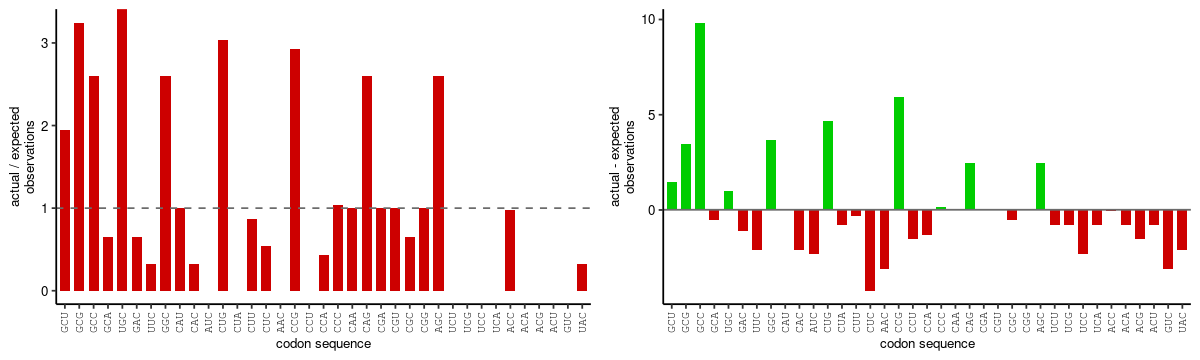

In [178]:
options(repr.plot.width=10, repr.plot.height=3)

b3<- ggplot(codon_prob, aes(x=codon, y=FC))+
  geom_bar(fill = "red3", stat="identity", width=0.7)+
  theme_classic() +
    labs(x = 'codon sequence', y = 'actual / expected
observations')+
    theme(text = element_text(size=8),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5, color='black', size=7,family="FreeMono"),
          axis.text.y = element_text(color='black', size=8),
          axis.title.y =  element_text(size=8),        
          plot.title=element_text(size=8),
          legend.title = element_text(size=0),
          legend.text = element_text(size=8),
         # plot.margin = margin(0, 0, 0, 0, "cm"),
          panel.grid = element_blank(),
         # panel.background = element_rect(fill='grey96',color='white')
         ) +
    geom_hline(yintercept=1, color='grey42', linetype='dashed')
    

#b3 <- gg.gap(plot=b3,segments=c(7,65),
#       ylim=c(0,70),rel_heights=c(3,0,1),tick_width = 5  )

ggsave('TS559_amino_acid_sequence_FC_hr.pdf', path='./figures/', device = cairo_pdf,  width=4.1, height=2, dpi = 400)


b3.1<- ggplot(codon_prob, aes(x=codon, y=difference))+
  geom_bar(aes(fill = color), stat="identity", width=0.7)+
  theme_classic() +
    labs(x = 'codon sequence', y = 'actual - expected
observations')+
    scale_fill_manual(values=c('green3','grey', 'red3'))+
    theme(text = element_text(size=8),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5, color='black', size=7,family="FreeMono"),
        axis.text.y = element_text(color='black', size=8),
        axis.title.y =  element_text(size=8),        
        plot.title=element_text(size=8),
        legend.position = 'none',
        legend.title = element_text(size=0),
        legend.text = element_text(size=8)
         
         ) +
    geom_hline(yintercept=0.01, color='grey42', linetype='solid')

ggsave('TS559_amino_acid_sequence_diff_hr.pdf', path='./figures/', device = cairo_pdf,  width=3.1, height=1.7, dpi = 400)

plot_grid(b3, b3.1, ncol=2, rel_widths=c(1, 1),rel_heights=c(1, 1), align = 'h', axis='bt')

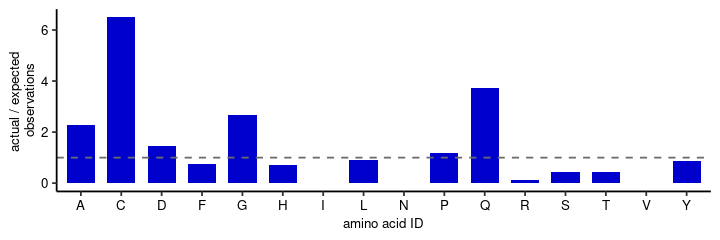

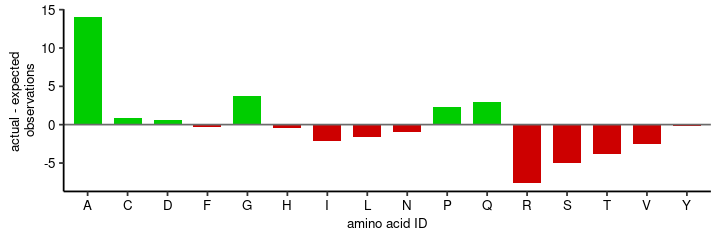

In [179]:
options(repr.plot.width=6, repr.plot.height=2)


b4<- ggplot(aaid_prob, aes(x=aa_ID, y=FC))+
  geom_bar(fill = "blue3", stat="identity", width=0.7)+
  theme_classic() +
    labs(x = 'amino acid ID', y = 'actual / expected 
observations')+
    theme(text = element_text(size=8),
        axis.text.x = element_text(color='black', size=8),
          axis.text.y = element_text(color='black', size=8),
          axis.title.y =  element_text(size=8),        
          plot.title=element_text(size=8),
          legend.position = c(0.3, 0.9),
          legend.title = element_text(size=0),
          legend.text = element_text(size=8) ) +
    geom_hline(yintercept=1, color='grey42', linetype='dashed')
b4
ggsave('TS559_amino_acid_ID_FC_hr.pdf', path='./figures/', device = cairo_pdf, width=3.9, height=2.3, dpi = 400)

b4.1 <- ggplot(aaid_prob, aes(x=aa_ID, y=difference))+
  geom_bar(aes(fill = color), stat="identity", width=0.7)+
  theme_classic() +
    scale_fill_manual(values=c('green3','red3'))+
    labs(x = 'amino acid ID', y = 'actual - expected 
observations')+
    theme(text = element_text(size=8),
        axis.text.x = element_text(color='black', size=8),
          axis.text.y = element_text(color='black', size=8),
          axis.title.y =  element_text(size=8),        
          plot.title=element_text(size=8),
          legend.position = 'none',
          legend.title = element_text(size=0),
          legend.text = element_text(size=8) ) +
    geom_hline(yintercept=0.01, color='grey42', linetype='solid')

b4.1
ggsave('TS559_amino_acid_ID_diff_hr.pdf', path='./figures/', device = cairo_pdf, width=3.9, height=2.3, dpi = 400)


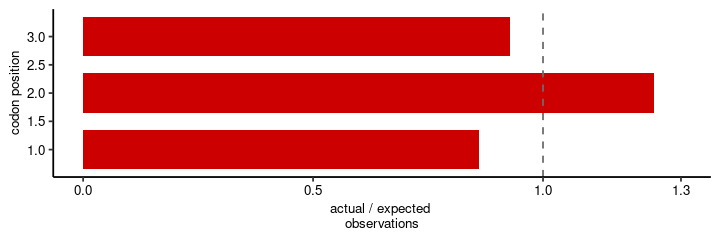

In [180]:
b5<- ggplot(aacodon_prob, aes(x=codon_position, y=FC))+
  geom_bar(fill = "red3", stat="identity", width=0.7)+
  theme_classic() +
    labs(x = 'codon position', y = 'actual / expected 
observations')+
    scale_y_continuous(limits=c(0,1.3), breaks=c(0,0.5,1,1.3)) +
    theme(text = element_text(size=8),
        axis.text.x = element_text(color='black', size=8),
          axis.text.y = element_text(color='black', size=8),
          axis.title.y =  element_text(size=8),        
          plot.title=element_text(size=8),
          legend.position = c(0.3, 0.9),
          legend.title = element_text(size=0),
          legend.text = element_text(size=8) ) +
    geom_hline(yintercept=1, color='grey42', linetype='dashed') +
coord_flip()

b5

ggsave('TS559_codon_position_FC.pdf', device = cairo_pdf, path='./figures/', width=2, height=1.5, dpi = 200)
